# Обучение трансформеров для классификации токсичных комментариев

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
from scipy.special import softmax
import re
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EvalPrediction, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score, average_precision_score
from sklearn.model_selection import train_test_split
from pandarallel import pandarallel
from T_functions import show_metrics, TextDataset, compute_train_metrics, freeze_layers, evaluate_checkpoint, plot_dil, find_best_t, url_re, spaces_re, clean_text_ft

filterwarnings('ignore')
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Загрузка и подготовка данных

In [3]:
df = pd.read_csv('modified_train.csv', usecols=['comment_text', 'toxicity_b', 'created_date'],parse_dates=['created_date'],
    date_format='ISO8601')
df = df[df['created_date'] >= '2016-04-01']
df = df.sort_values(by='created_date')[['comment_text', 'toxicity_b']].reset_index(drop=True)

### Очистка текста

In [4]:
df['comment_text'] = df['comment_text'].parallel_apply(clean_text_ft)

In [5]:
df.head()

,comment_text,toxicity_b
0,"If there is a special session,it should be hel...",0
1,"As they should my friend, as they should. It's...",0
2,Just got back from the 5th Ave mall and was pa...,0
3,"Why bother going into Dutch, Just run the Trus...",0
4,"Sounds like a lot of stereotyping going on, CS...",0


### Разделение данных на Train-Val-Test и подготовка данных для использования в моделях

In [6]:
train_df, test_df = df.loc[:1428245], df.loc[1428246:]
train_df, val_df = train_df.loc[:1142596], train_df.loc[1142597:]

In [7]:
train_df.toxicity_b.value_counts(normalize = True).to_frame()

,proportion
toxicity_b,
0,0.891065
1,0.108935


In [8]:
val_df.toxicity_b.value_counts(normalize = True).to_frame()

,proportion
toxicity_b,
0,0.883469
1,0.116531


In [9]:
test_df.toxicity_b.value_counts(normalize = True).to_frame()

,proportion
toxicity_b,
0,0.882343
1,0.117657


## Обучение моделей на 96K наблюдениях

Для начала определим на довольно легковесной модели сколько нам необходимо эпох для дообучения трансформеров на наших данных. Для этого обучим модель `DistilBERT`.

Для тестирования возьмем случайные семплы из `train_df`, `val_df` и `test_df`, чтобы в совокупности у нас было 150K наблюдений, где для обучения будет использовано 96К наблюдений, для валидации 24К наблюдений и для теста 30К наблюдений.

In [10]:
train_dfs = train_df.sample(96000, random_state=42)
val_dfs = val_df.sample(24000, random_state=42)
test_dfs = test_df.sample(30000, random_state=42)

In [11]:
train_dfs.toxicity_b.value_counts(normalize = True).to_frame()

,proportion
toxicity_b,
0,0.891969
1,0.108031


In [12]:
val_dfs.toxicity_b.value_counts(normalize = True).to_frame()

,proportion
toxicity_b,
0,0.883958
1,0.116042


In [13]:
test_dfs.toxicity_b.value_counts(normalize = True).to_frame()

,proportion
toxicity_b,
0,0.883433
1,0.116567


### DistilBERT

In [21]:
tokenizer_dbert = AutoTokenizer.from_pretrained('distilbert-base-uncased')

In [22]:
train_dataset = TextDataset(train_dfs, tokenizer_dbert)
val_dataset = TextDataset(val_dfs, tokenizer_dbert)
test_dataset = TextDataset(test_dfs, tokenizer_dbert)

In [23]:
model_dbert = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
training_args = TrainingArguments(
    output_dir='./dbert_training_results',
    eval_strategy='epoch',
    learning_rate=1e-5,
    warmup_ratio=0.1,
    lr_scheduler_type='linear',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=40,
    weight_decay=0.01,
    save_strategy='epoch',
    metric_for_best_model='eval_loss',
    greater_is_better=False,
    load_best_model_at_end=True,
    fp16=True,
    report_to='wandb'
)

early_stop = EarlyStoppingCallback(
    early_stopping_patience=2,
    early_stopping_threshold=0.0
)

In [25]:
trainer = Trainer(
    model=model_dbert,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[early_stop],
    compute_metrics=compute_train_metrics
)

In [26]:
trainer.train()

Epoch,Training Loss,Validation Loss,Roc Auc,Pr Auc,F1,Accuracy,Precision,Recall
1,0.200900,0.198557,0.931409,0.706623,0.635411,0.920292,0.692851,0.586765
2,0.175100,0.188926,0.945038,0.752045,0.679494,0.920875,0.652724,0.708553
3,0.157400,0.185568,0.948450,0.762749,0.687924,0.923333,0.663830,0.713833
4,0.143000,0.197883,0.947398,0.761407,0.687129,0.921000,0.646785,0.732841
5,0.112900,0.234385,0.943609,0.751126,0.671223,0.925833,0.706180,0.639564


TrainOutput(global_step=15000, training_loss=0.18015300674438475, metrics={'train_runtime': 2276.6217, 'train_samples_per_second': 1686.71, 'train_steps_per_second': 52.71, 'total_flos': 6.358435135488e+16, 'train_loss': 0.18015300674438475, 'epoch': 5.0})

**Метрики и графики для лучшей полученной модели**

In [27]:
train_preds = trainer.predict(train_dataset)
val_preds = trainer.predict(val_dataset)
test_preds = trainer.predict(test_dataset)

y_train = train_preds.label_ids
y_val = val_preds.label_ids
y_test = test_preds.label_ids

y_pred_train = np.argmax(train_preds.predictions, axis=1)
y_pred_val = np.argmax(val_preds.predictions, axis=1)
y_pred_test = np.argmax(test_preds.predictions, axis=1)

y_proba_train = torch.softmax(torch.tensor(train_preds.predictions), dim=-1)[:, 1].numpy()
y_proba_val = torch.softmax(torch.tensor(val_preds.predictions), dim=-1)[:, 1].numpy()
y_proba_test = torch.softmax(torch.tensor(test_preds.predictions), dim=-1)[:, 1].numpy()

DistilBERT Toxic Classification

Precision		Recall			F1

Train: 0.75		Train: 0.80		Train: 0.77
Val: 0.66		Val: 0.71		Val: 0.69
Test: 0.66		Test: 0.72		Test: 0.69


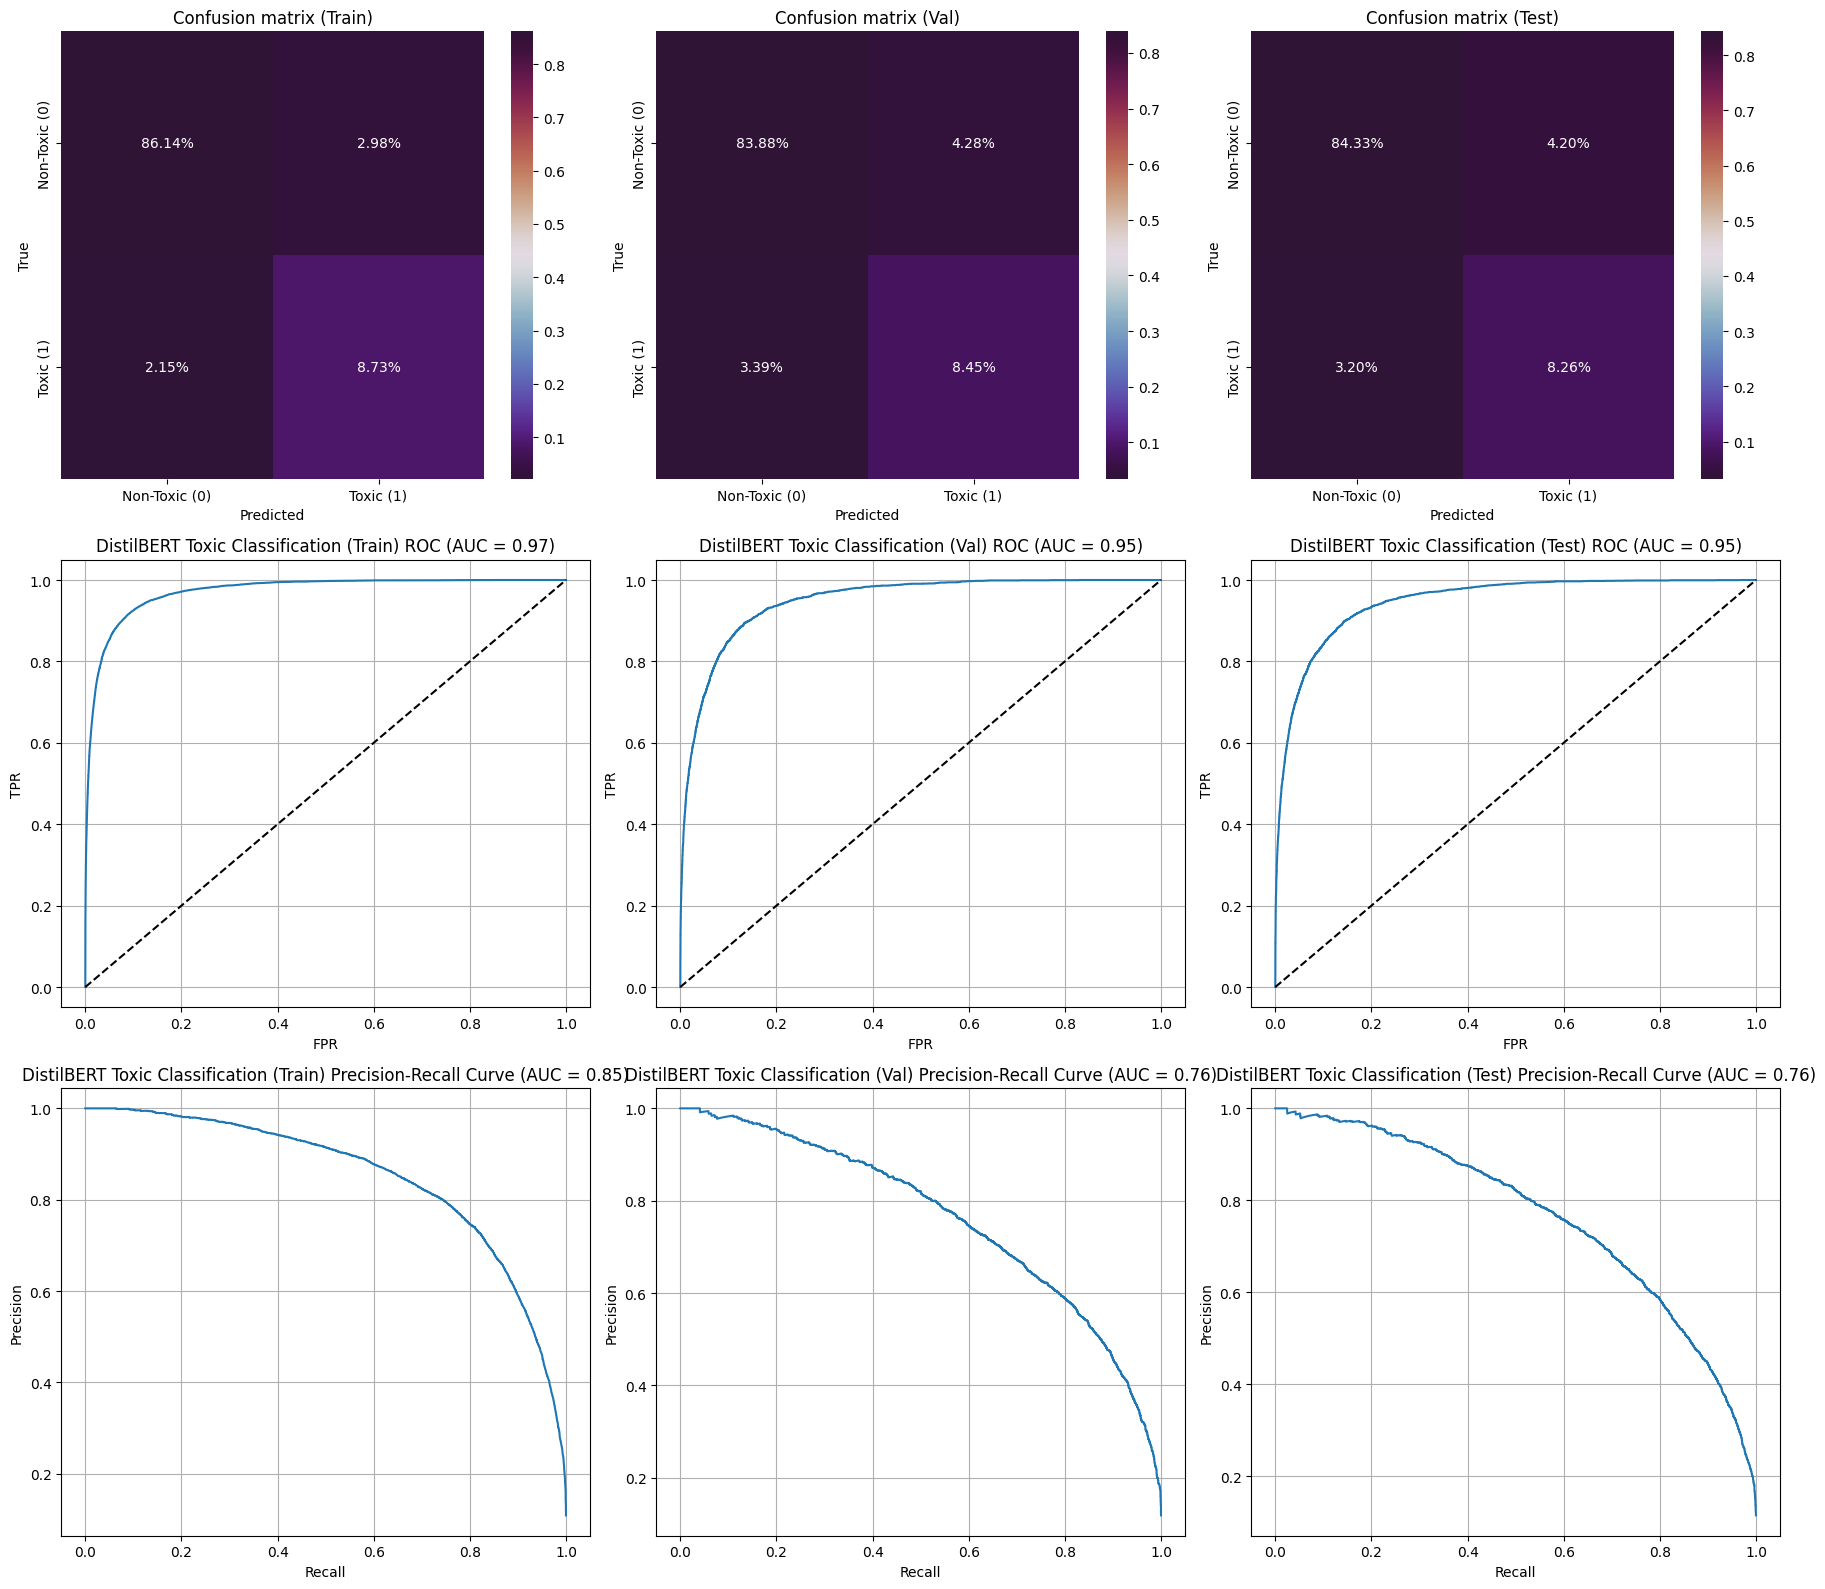

In [28]:
show_metrics(
    y_train, y_val, y_test,
    y_pred_train, y_pred_val, y_pred_test,
    y_proba_train, y_proba_val, y_proba_test,
    title="DistilBERT Toxic Classification"
)

**Метрики по эпохам на train/val**

In [29]:
checkpoints = [
    './dbert_training_results/checkpoint-3000',
    './dbert_training_results/checkpoint-6000',
    './dbert_training_results/checkpoint-9000',
    './dbert_training_results/checkpoint-12000',
    './dbert_training_results/checkpoint-15000'
]

In [31]:
all_metrics = []


datasets = [
    ("train", train_dataset),
    ("val", val_dataset),
]

for path in checkpoints:
    for name, dataset in datasets:
        metrics = evaluate_checkpoint(
            path=path,
            dataset=dataset,
            dataset_name=name,
            tokenizer=tokenizer_dbert,
            compute_metrics=compute_train_metrics
        )
        all_metrics.append(metrics)

In [36]:
metrics_data = pd.DataFrame(all_metrics)
metrics_data['epoch'] = [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
metrics_data = metrics_data[['eval_loss', 'eval_roc_auc', 'eval_pr_auc', 'eval_f1',
              'eval_accuracy', 'eval_precision', 'eval_recall', 'epoch', 'dataset']]

In [37]:
metrics_data

,eval_loss,eval_roc_auc,eval_pr_auc,eval_f1,eval_accuracy,eval_precision,eval_recall,epoch,dataset
0,0.182742,0.934728,0.720343,0.642920,0.928156,0.700079,0.594390,1,train
1,0.198555,0.931408,0.706629,0.635411,0.920292,0.692851,0.586765,1,val
2,0.161137,0.956396,0.790756,0.712237,0.935010,0.687227,0.739135,2,train
3,0.188933,0.945036,0.752039,0.679271,0.920833,0.652611,0.708201,2,val
4,0.130364,0.971765,0.850650,0.772608,0.948635,0.745351,0.801934,3,train
5,0.185571,0.948450,0.762749,0.687468,0.923208,0.663285,0.713481,3,val
6,0.104377,0.983635,0.912182,0.823419,0.958781,0.771211,0.883209,4,train
7,0.197888,0.947397,0.761405,0.687242,0.921042,0.646986,0.732841,4,val
8,0.059505,0.993298,0.960843,0.900912,0.978729,0.913501,0.888666,5,train
9,0.234381,0.943611,0.751126,0.670975,0.925750,0.705631,0.639564,5,val


**Loss на Train и Val по эпохам**

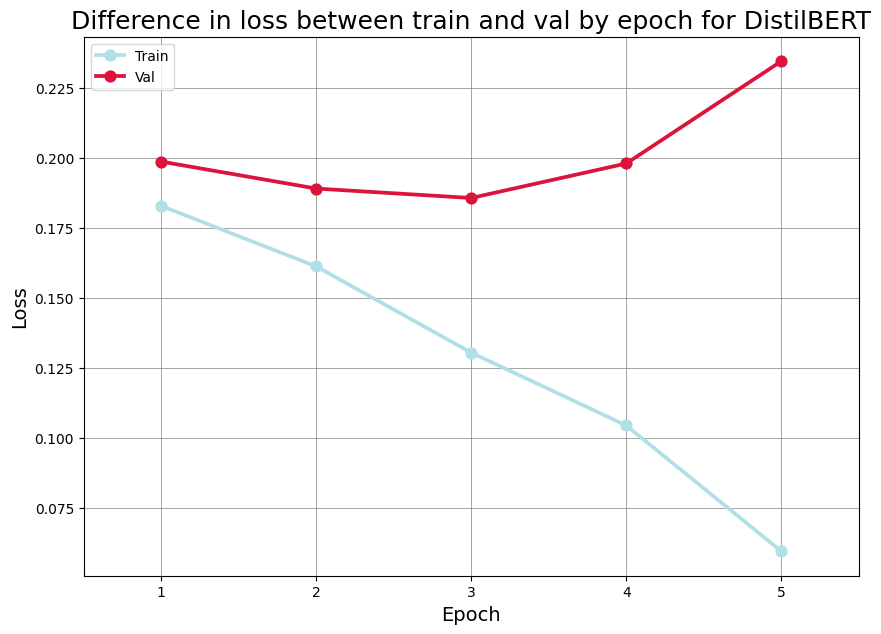

In [46]:
plot_dil(metrics_data, 'DistilBERT')

**Подбор порога вероятности**

In [56]:
find_best_t(y_proba_val, val_dfs)

Лучший порог: 0.5000
Лучший F1: 0.6879


0.5

### BERT

Для модели `BERT` и последующих моделей урежем количество эпох до 3, так как ранее проделанные исследования показали, что в нашем случае переобучение моделей трансформеров наступает после или ровно в 3 эпоху

In [14]:
tokenizer_bert = AutoTokenizer.from_pretrained('bert-base-uncased')

In [15]:
train_dataset = TextDataset(train_dfs, tokenizer_bert)
val_dataset = TextDataset(val_dfs, tokenizer_bert)
test_dataset = TextDataset(test_dfs, tokenizer_bert)

In [16]:
model_bert = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
training_args = TrainingArguments(
    output_dir='./bert_training_results',
    eval_strategy='epoch',
    learning_rate=1e-5,
    warmup_ratio=0.1,
    lr_scheduler_type='linear',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy='epoch',
    metric_for_best_model='eval_loss',
    greater_is_better=False,
    load_best_model_at_end=True,
    fp16=True,
    report_to='none'
)


In [18]:
trainer = Trainer(
    model=model_bert,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_train_metrics
)

In [19]:
trainer.train()

Epoch,Training Loss,Validation Loss,Roc Auc,Pr Auc,F1,Accuracy,Precision,Recall
1,0.169400,0.185112,0.948414,0.759025,0.685179,0.925833,0.675148,0.695512
2,0.144900,0.176588,0.951457,0.777936,0.659729,0.931875,0.784653,0.569120
3,0.114500,0.202656,0.950003,0.770095,0.687556,0.926875,0.681850,0.693357


TrainOutput(global_step=9000, training_loss=0.1540130432976617, metrics={'train_runtime': 2510.1261, 'train_samples_per_second': 114.735, 'train_steps_per_second': 3.585, 'total_flos': 7.577598394368e+16, 'train_loss': 0.1540130432976617, 'epoch': 3.0})

**Метрики и графики для лучшей полученной модели на выборках Train/val/test**

In [20]:
train_preds = trainer.predict(train_dataset)
val_preds = trainer.predict(val_dataset)
test_preds = trainer.predict(test_dataset)

y_train = train_preds.label_ids
y_val = val_preds.label_ids
y_test = test_preds.label_ids

y_pred_train = np.argmax(train_preds.predictions, axis=1)
y_pred_val = np.argmax(val_preds.predictions, axis=1)
y_pred_test = np.argmax(test_preds.predictions, axis=1)

y_proba_train = torch.softmax(torch.tensor(train_preds.predictions), dim=-1)[:, 1].numpy()
y_proba_val = torch.softmax(torch.tensor(val_preds.predictions), dim=-1)[:, 1].numpy()
y_proba_test = torch.softmax(torch.tensor(test_preds.predictions), dim=-1)[:, 1].numpy()

BERT Toxic Classification

Precision		Recall			F1

Train: 0.90		Train: 0.72		Train: 0.80
Val: 0.78		Val: 0.57		Val: 0.66
Test: 0.78		Test: 0.59		Test: 0.67


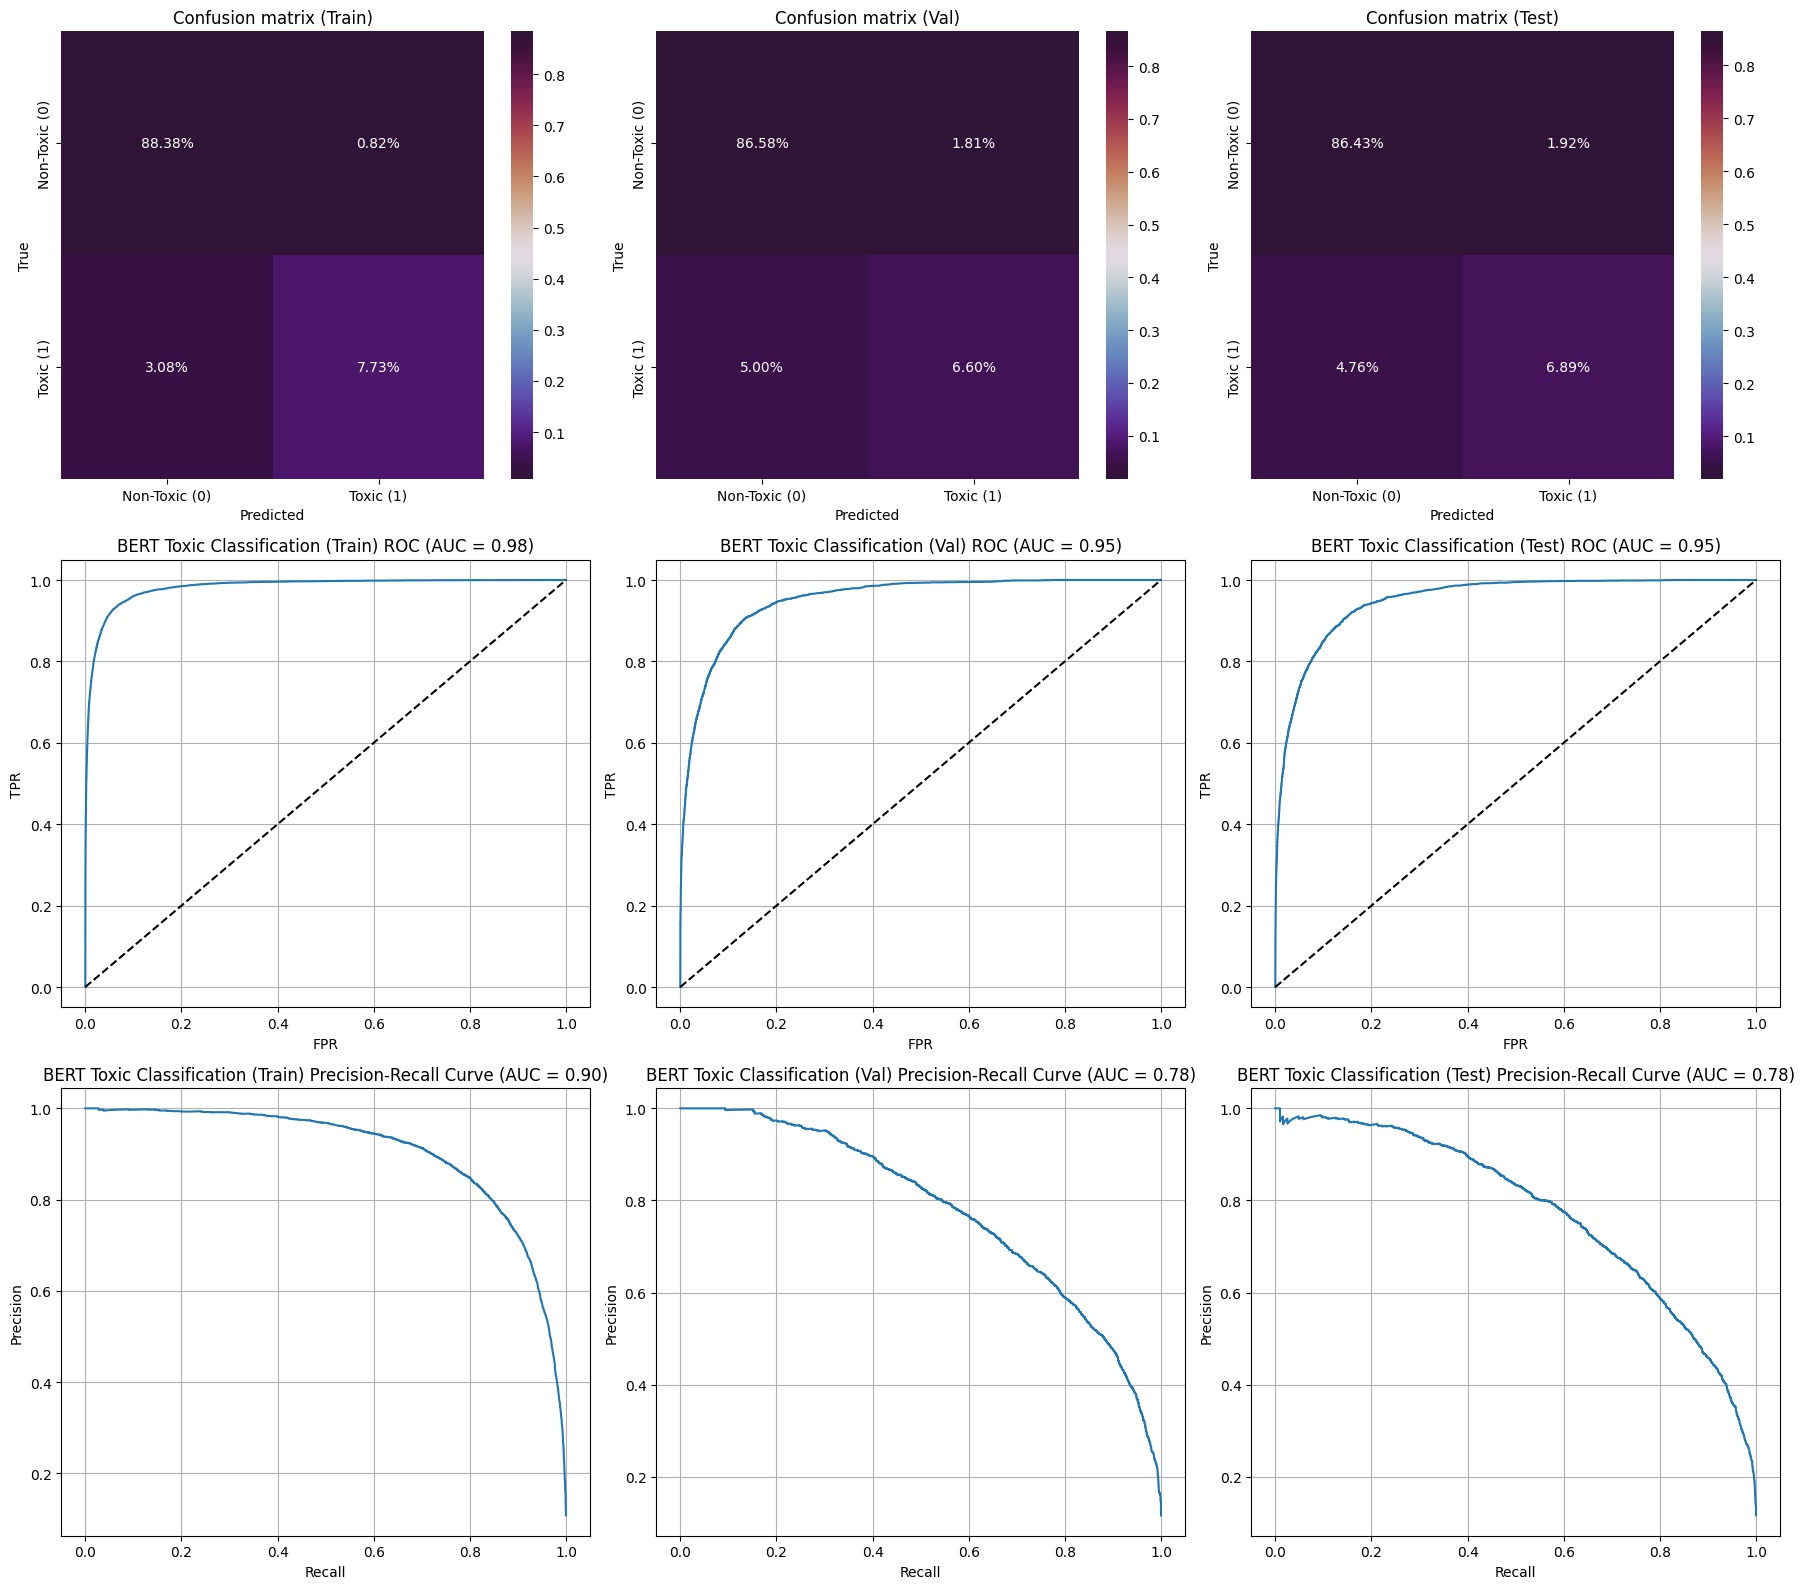

In [21]:
show_metrics(
    y_train, y_val, y_test,
    y_pred_train, y_pred_val, y_pred_test,
    y_proba_train, y_proba_val, y_proba_test,
    title="BERT Toxic Classification"
)

**Метрики по эпохам на train/val**

In [22]:
checkpoints = [
    './bert_training_results/checkpoint-3000',
    './bert_training_results/checkpoint-6000',
    './bert_training_results/checkpoint-9000'
]

In [24]:
all_metrics = []


datasets = [
    ("train", train_dataset),
    ("val", val_dataset),
]

for path in checkpoints:
    for name, dataset in datasets:
        metrics = evaluate_checkpoint(
            path=path,
            dataset=dataset,
            dataset_name=name,
            tokenizer=tokenizer_bert,
            compute_metrics=compute_train_metrics
        )
        all_metrics.append(metrics)

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: inreleppik (inreleppik-hse-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [26]:
metrics_data = pd.DataFrame(all_metrics)
metrics_data['epoch'] = [1, 1, 2, 2, 3, 3]
metrics_data = metrics_data[['eval_loss', 'eval_roc_auc', 'eval_pr_auc', 'eval_f1',
              'eval_accuracy', 'eval_precision', 'eval_recall', 'epoch', 'dataset']]

In [27]:
metrics_data

,eval_loss,eval_roc_auc,eval_pr_auc,eval_f1,eval_accuracy,eval_precision,eval_recall,epoch,dataset
0,0.143282,0.966754,0.826523,0.744265,0.943677,0.730412,0.758654,1,train
1,0.185113,0.948413,0.759010,0.685300,0.925875,0.675384,0.695512,1,val
2,0.099690,0.982188,0.904874,0.798514,0.961010,0.903851,0.715167,2,train
3,0.176589,0.951456,0.777928,0.659729,0.931875,0.784653,0.569120,2,val
4,0.084752,0.986838,0.930235,0.857768,0.968854,0.846493,0.869347,3,train
5,0.202658,0.950004,0.770115,0.687556,0.926875,0.681850,0.693357,3,val


**Loss на Train и Val по эпохам**

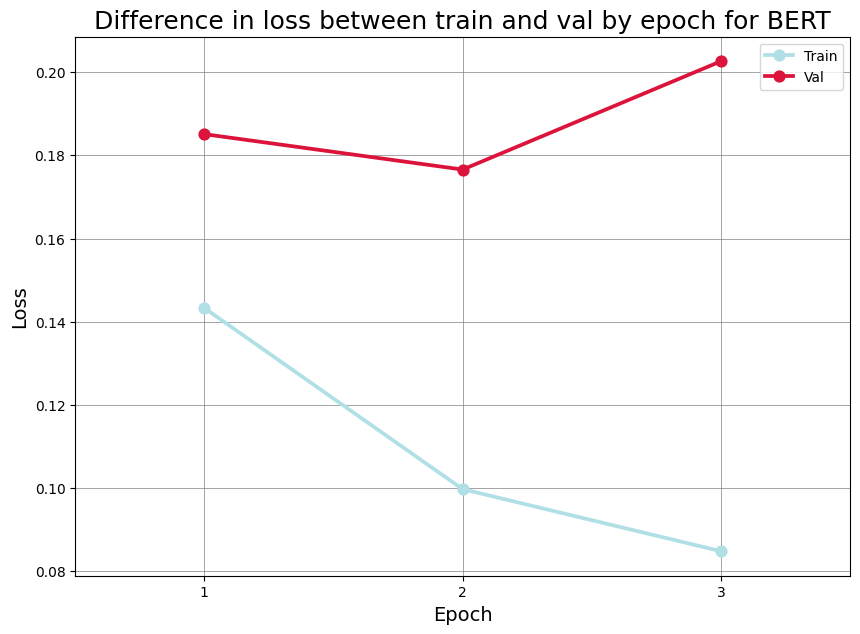

In [28]:
plot_dil(metrics_data, 'BERT')

**Подбор порога вероятности**

In [29]:
find_best_t(y_proba_val, val_dfs)

Лучший порог: 0.1900
Лучший F1: 0.6929


0.19

### RoBERTa

In [30]:
tokenizer_roberta = AutoTokenizer.from_pretrained('roberta-base')

In [31]:
train_dataset = TextDataset(train_dfs, tokenizer_roberta)
val_dataset = TextDataset(val_dfs, tokenizer_roberta)
test_dataset = TextDataset(test_dfs, tokenizer_roberta)

In [32]:
model_roberta = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
training_args = TrainingArguments(
    output_dir='./roberta_training_results',
    eval_strategy='epoch',
    learning_rate=1e-5,
    warmup_ratio=0.1,
    lr_scheduler_type='linear',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy='epoch',
    metric_for_best_model='eval_loss',
    greater_is_better=False,
    load_best_model_at_end=True,
    fp16=True,
    report_to='none'
)

In [34]:
trainer = Trainer(
    model=model_roberta,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_train_metrics
)

In [35]:
trainer.train()

Epoch,Training Loss,Validation Loss,Roc Auc,Pr Auc,F1,Accuracy,Precision,Recall
1,0.173500,0.184425,0.950216,0.768672,0.682498,0.924792,0.668966,0.696589
2,0.151500,0.169581,0.952815,0.779816,0.668984,0.932542,0.776828,0.587433
3,0.122100,0.194797,0.952108,0.777513,0.689342,0.925792,0.670285,0.709515


TrainOutput(global_step=9000, training_loss=0.16284460661146377, metrics={'train_runtime': 2514.8306, 'train_samples_per_second': 114.521, 'train_steps_per_second': 3.579, 'total_flos': 7.577598394368e+16, 'train_loss': 0.16284460661146377, 'epoch': 3.0})

**Метрики и графики для лучшей полученной модели на выборках Train/val/test**

In [36]:
train_preds = trainer.predict(train_dataset)
val_preds = trainer.predict(val_dataset)
test_preds = trainer.predict(test_dataset)

y_train = train_preds.label_ids
y_val = val_preds.label_ids
y_test = test_preds.label_ids

y_pred_train = np.argmax(train_preds.predictions, axis=1)
y_pred_val = np.argmax(val_preds.predictions, axis=1)
y_pred_test = np.argmax(test_preds.predictions, axis=1)

y_proba_train = torch.softmax(torch.tensor(train_preds.predictions), dim=-1)[:, 1].numpy()
y_proba_val = torch.softmax(torch.tensor(val_preds.predictions), dim=-1)[:, 1].numpy()
y_proba_test = torch.softmax(torch.tensor(test_preds.predictions), dim=-1)[:, 1].numpy()

RoBERTa Toxic Classification

Precision		Recall			F1

Train: 0.86		Train: 0.70		Train: 0.77
Val: 0.78		Val: 0.59		Val: 0.67
Test: 0.77		Test: 0.61		Test: 0.68


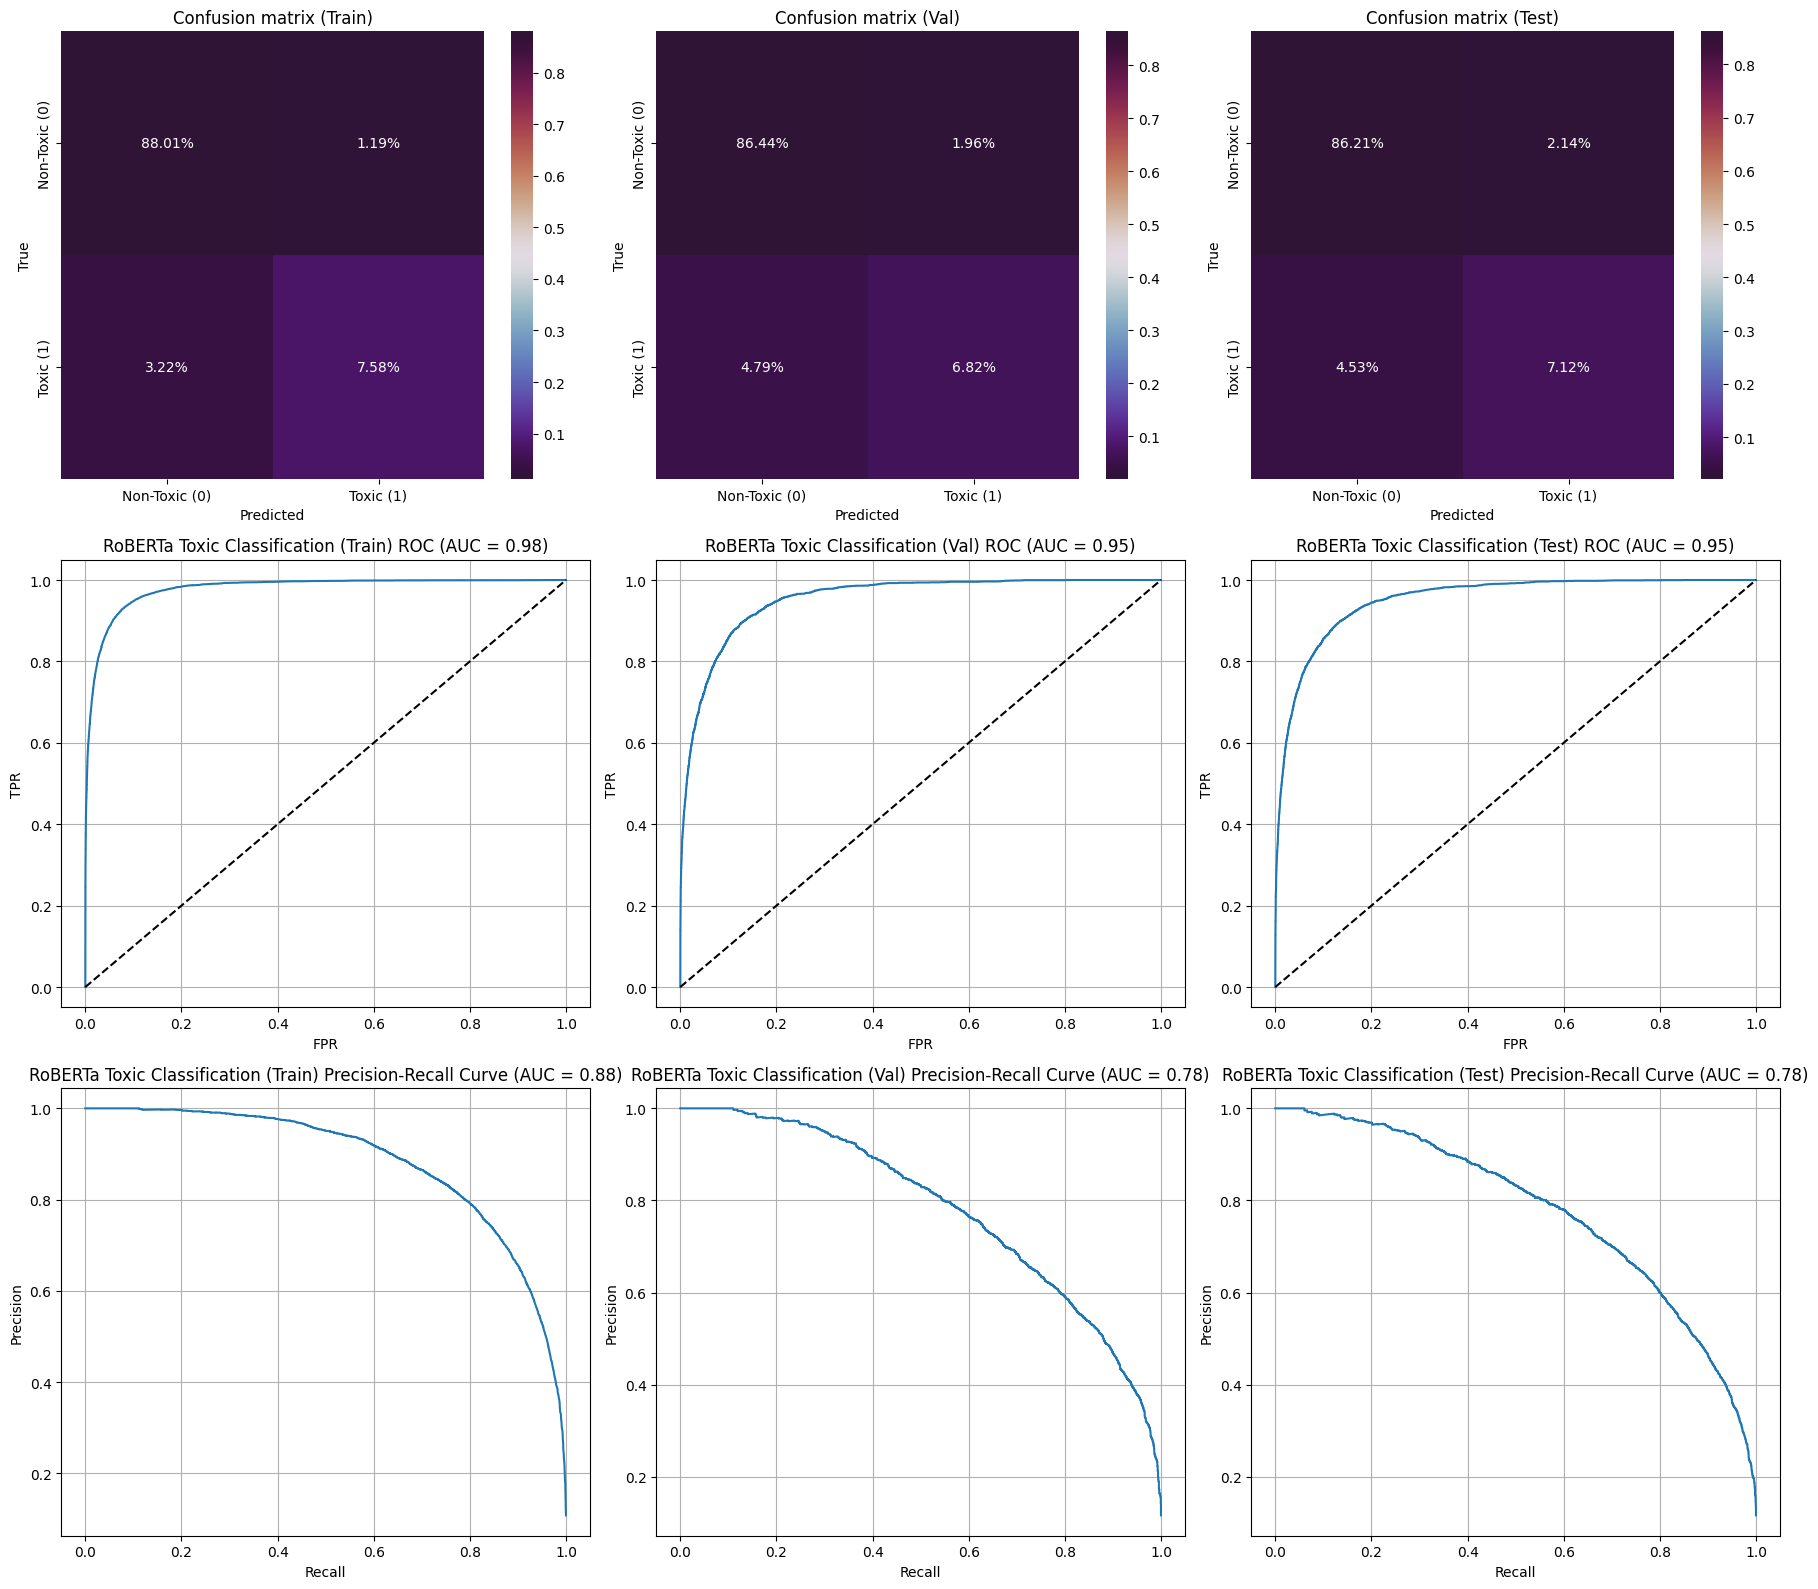

In [37]:
show_metrics(
    y_train, y_val, y_test,
    y_pred_train, y_pred_val, y_pred_test,
    y_proba_train, y_proba_val, y_proba_test,
    title="RoBERTa Toxic Classification"
)

**Метрики по эпохам на train/val**

In [38]:
checkpoints = [
    './roberta_training_results/checkpoint-3000',
    './roberta_training_results/checkpoint-6000',
    './roberta_training_results/checkpoint-9000'
]

In [42]:
all_metrics = []


datasets = [
    ("train", train_dataset),
    ("val", val_dataset),
]

for path in checkpoints:
    for name, dataset in datasets:
        metrics = evaluate_checkpoint(
            path=path,
            dataset=dataset,
            dataset_name=name,
            tokenizer=tokenizer_roberta,
            compute_metrics=compute_train_metrics
        )
        all_metrics.append(metrics)

In [43]:
metrics_data = pd.DataFrame(all_metrics)
metrics_data['epoch'] = [1, 1, 2, 2, 3, 3]
metrics_data = metrics_data[['eval_loss', 'eval_roc_auc', 'eval_pr_auc', 'eval_f1',
              'eval_accuracy', 'eval_precision', 'eval_recall', 'epoch', 'dataset']]

In [46]:
metrics_data 

,eval_loss,eval_roc_auc,eval_pr_auc,eval_f1,eval_accuracy,eval_precision,eval_recall,epoch,dataset
0,0.144650,0.965797,0.824126,0.736012,0.941417,0.717095,0.755954,1,train
1,0.184423,0.950218,0.768669,0.682738,0.924875,0.669427,0.696589,1,val
2,0.109067,0.978387,0.882917,0.774465,0.955875,0.864701,0.701282,2,train
3,0.169584,0.952813,0.779808,0.668712,0.932500,0.776722,0.587074,2,val
4,0.100820,0.982963,0.907440,0.823821,0.960771,0.800091,0.849002,3,train
5,0.194799,0.952109,0.777511,0.689342,0.925792,0.670285,0.709515,3,val


**Loss на Train и Val по эпохам**

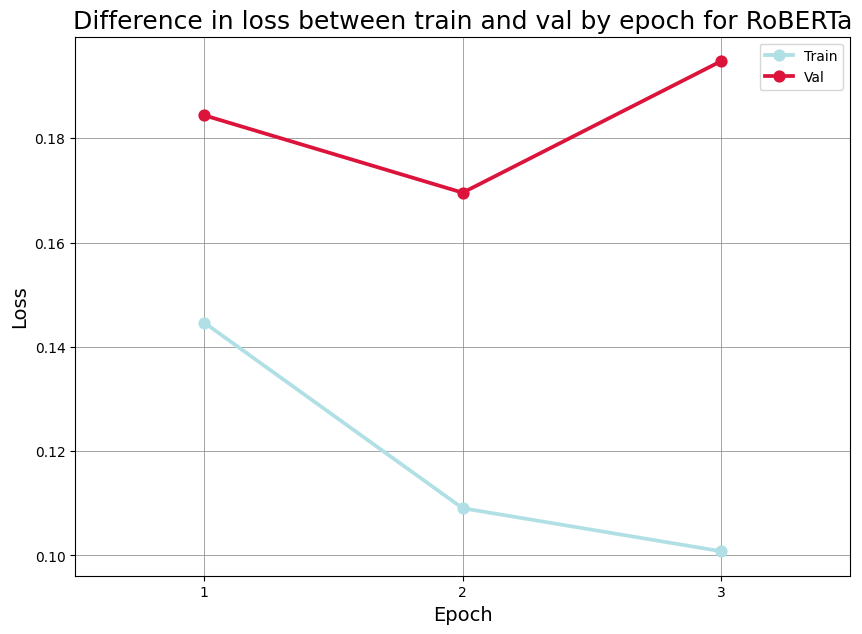

In [44]:
plot_dil(metrics_data, 'RoBERTa')

**Подбор порога вероятности**

In [45]:
find_best_t(y_proba_val, val_dfs)

Лучший порог: 0.3200
Лучший F1: 0.6927


0.32

### RoBERTa Large

In [14]:
tokenizer_robertal = AutoTokenizer.from_pretrained('roberta-large')

In [15]:
train_dataset = TextDataset(train_dfs, tokenizer_robertal)
val_dataset = TextDataset(val_dfs, tokenizer_robertal)
test_dataset = TextDataset(test_dfs, tokenizer_robertal)

In [16]:
model_robertal = AutoModelForSequenceClassification.from_pretrained("roberta-large", num_labels=2)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
training_args = TrainingArguments(
    output_dir='./robertal_training_results',
    eval_strategy='epoch',
    learning_rate=1e-5,
    warmup_ratio=0.1,
    lr_scheduler_type='linear',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy='epoch',
    metric_for_best_model='eval_loss',
    greater_is_better=False,
    load_best_model_at_end=True,
    fp16=True,
    report_to='none'
)

In [18]:
trainer = Trainer(
    model=model_robertal,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_train_metrics
)

In [19]:
trainer.train()

Epoch,Training Loss,Validation Loss,Roc Auc,Pr Auc,F1,Accuracy,Precision,Recall
1,0.167500,0.180505,0.953695,0.774693,0.698457,0.928333,0.682425,0.715260
2,0.138600,0.171229,0.954026,0.784082,0.680024,0.932792,0.759752,0.615440
3,0.096500,0.229378,0.951099,0.772307,0.691434,0.925250,0.663585,0.721724


TrainOutput(global_step=9000, training_loss=0.14945154825846355, metrics={'train_runtime': 7234.3824, 'train_samples_per_second': 39.81, 'train_steps_per_second': 1.244, 'total_flos': 2.68396232638464e+17, 'train_loss': 0.14945154825846355, 'epoch': 3.0})

**Метрики и графики для лучшей полученной модели на выборках Train/val/test**

In [20]:
train_preds = trainer.predict(train_dataset)
val_preds = trainer.predict(val_dataset)
test_preds = trainer.predict(test_dataset)

y_train = train_preds.label_ids
y_val = val_preds.label_ids
y_test = test_preds.label_ids

y_pred_train = np.argmax(train_preds.predictions, axis=1)
y_pred_val = np.argmax(val_preds.predictions, axis=1)
y_pred_test = np.argmax(test_preds.predictions, axis=1)

y_proba_train = torch.softmax(torch.tensor(train_preds.predictions), dim=-1)[:, 1].numpy()
y_proba_val = torch.softmax(torch.tensor(val_preds.predictions), dim=-1)[:, 1].numpy()
y_proba_test = torch.softmax(torch.tensor(test_preds.predictions), dim=-1)[:, 1].numpy()

RoBERTa Large Toxic Classification

Precision		Recall			F1

Train: 0.90		Train: 0.77		Train: 0.83
Val: 0.76		Val: 0.62		Val: 0.68
Test: 0.77		Test: 0.64		Test: 0.70


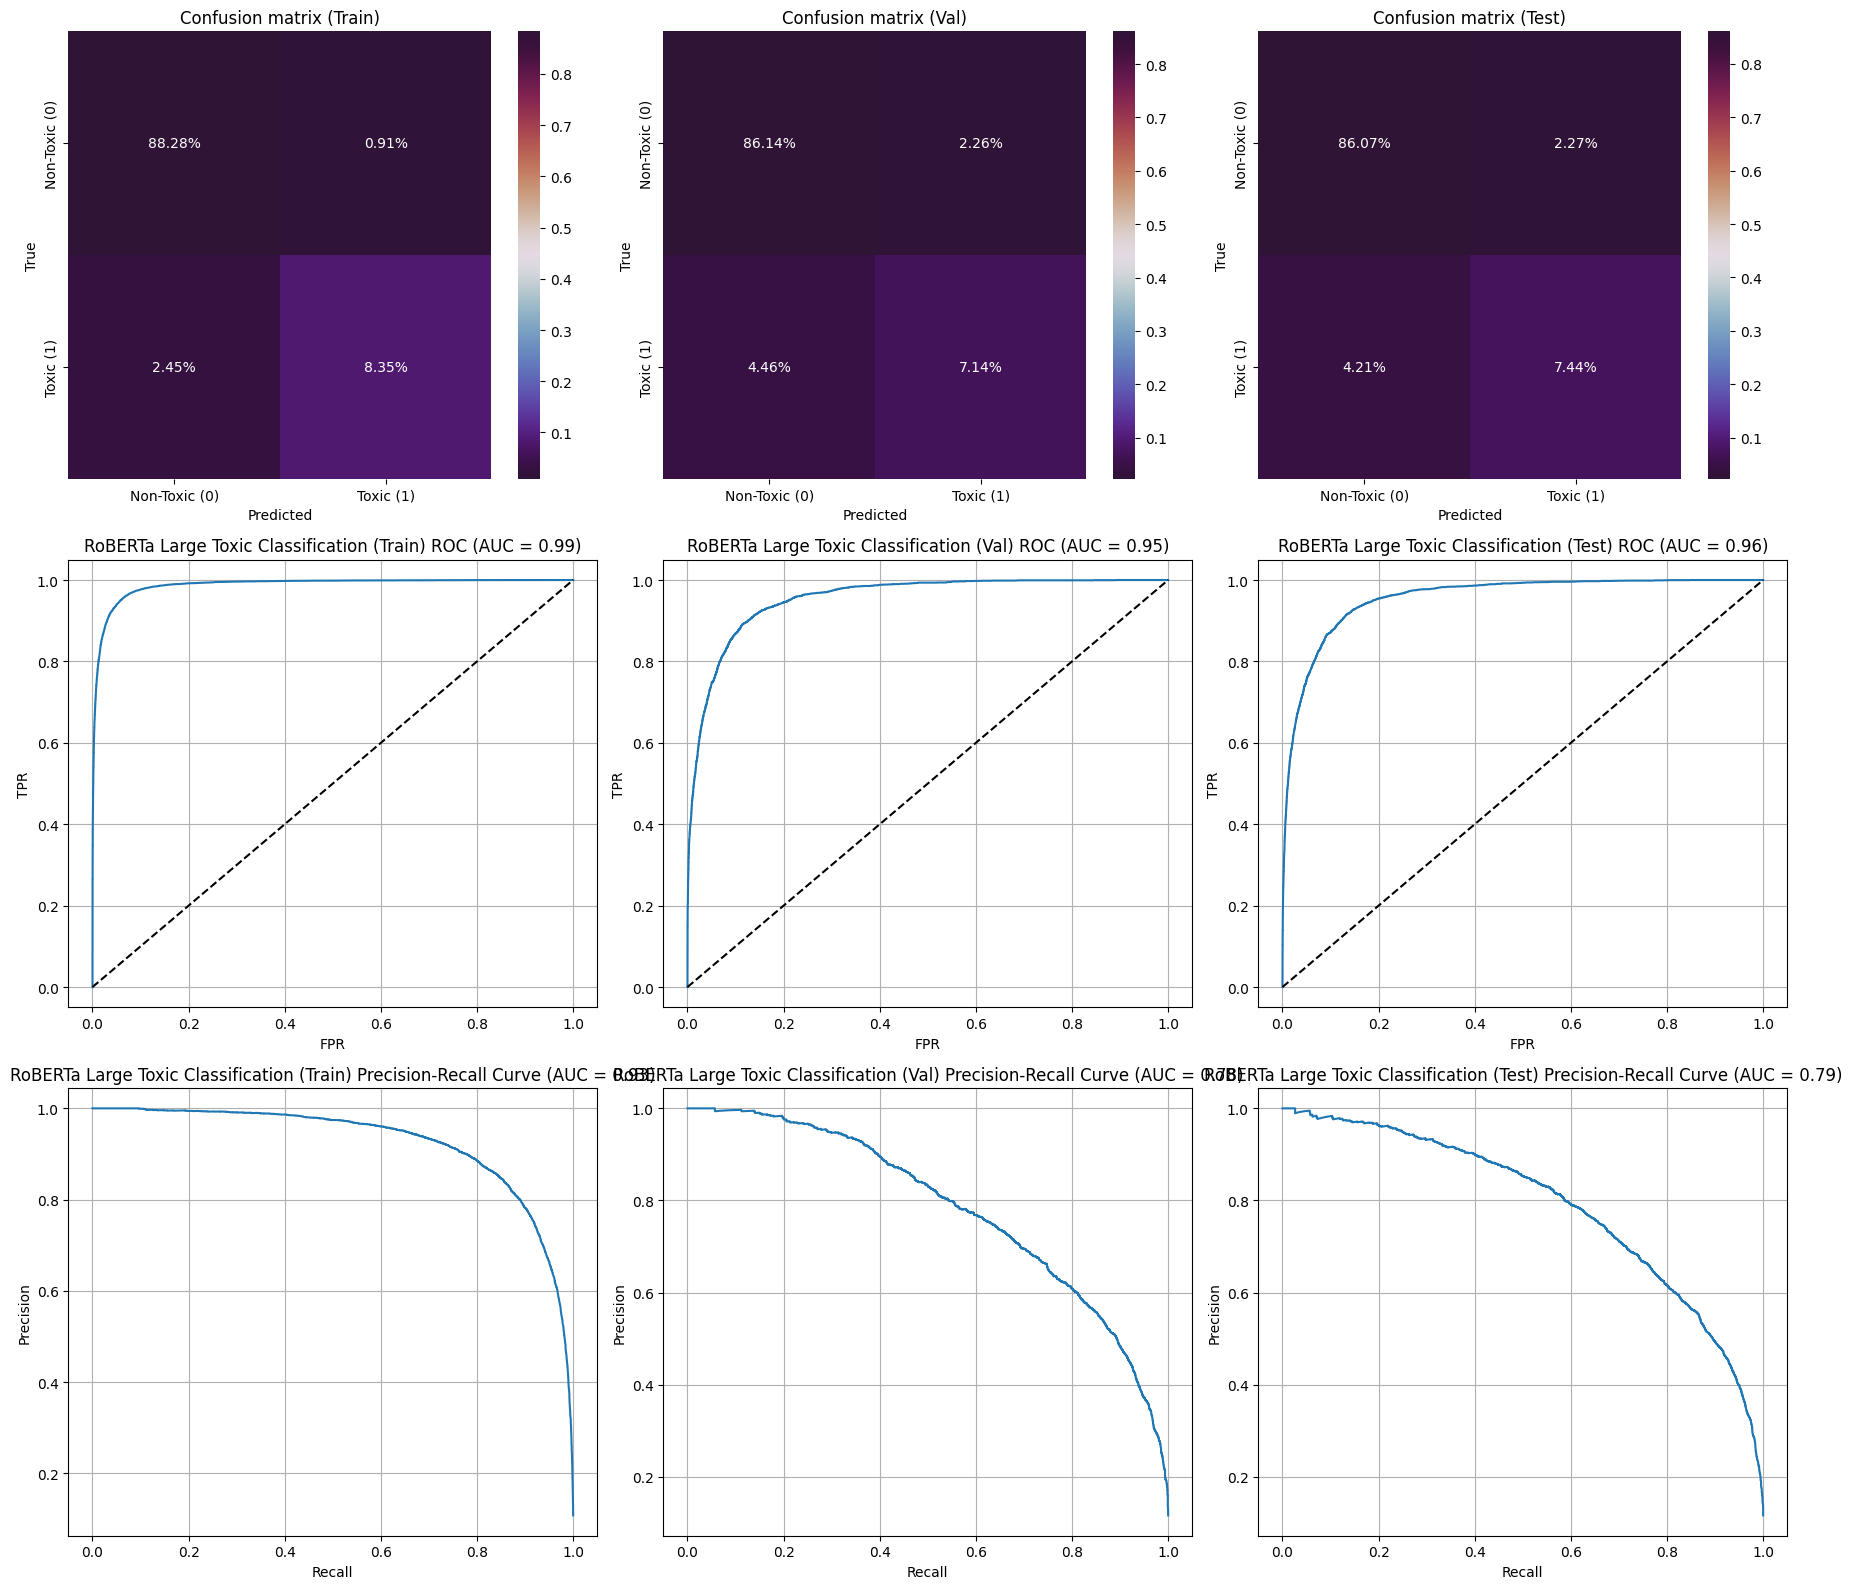

In [21]:
show_metrics(
    y_train, y_val, y_test,
    y_pred_train, y_pred_val, y_pred_test,
    y_proba_train, y_proba_val, y_proba_test,
    title="RoBERTa Large Toxic Classification"
)

**Метрики по эпохам на train/val**

In [16]:
checkpoints = [
    './robertal_training_results/checkpoint-3000',
    './robertal_training_results/checkpoint-6000',
    './robertal_training_results/checkpoint-9000'
]

In [17]:
all_metrics = []


datasets = [
    ("train", train_dataset),
    ("val", val_dataset),
]

for path in checkpoints:
    for name, dataset in datasets:
        metrics = evaluate_checkpoint(
            path=path,
            dataset=dataset,
            dataset_name=name,
            tokenizer=tokenizer_robertal,
            compute_metrics=compute_train_metrics
        )
        all_metrics.append(metrics)

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: inreleppik (inreleppik-hse-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [18]:
metrics_data = pd.DataFrame(all_metrics)
metrics_data['epoch'] = [1, 1, 2, 2, 3, 3]
metrics_data = metrics_data[['eval_loss', 'eval_roc_auc', 'eval_pr_auc', 'eval_f1',
              'eval_accuracy', 'eval_precision', 'eval_recall', 'epoch', 'dataset']]

In [19]:
metrics_data

,eval_loss,eval_roc_auc,eval_pr_auc,eval_f1,eval_accuracy,eval_precision,eval_recall,epoch,dataset
0,0.134334,0.971151,0.838939,0.752756,0.945573,0.739082,0.766946,1,train
1,0.180496,0.953695,0.774711,0.698685,0.928375,0.682534,0.715619,1,val
2,0.085217,0.987218,0.925106,0.832269,0.966344,0.901484,0.772925,2,train
3,0.171240,0.954024,0.784093,0.680024,0.932792,0.759752,0.615440,2,val
4,0.067401,0.992516,0.955893,0.887535,0.974802,0.856976,0.920355,3,train
5,0.229376,0.951101,0.772330,0.691553,0.925292,0.663804,0.721724,3,val


**Loss на Train и Val по эпохам**

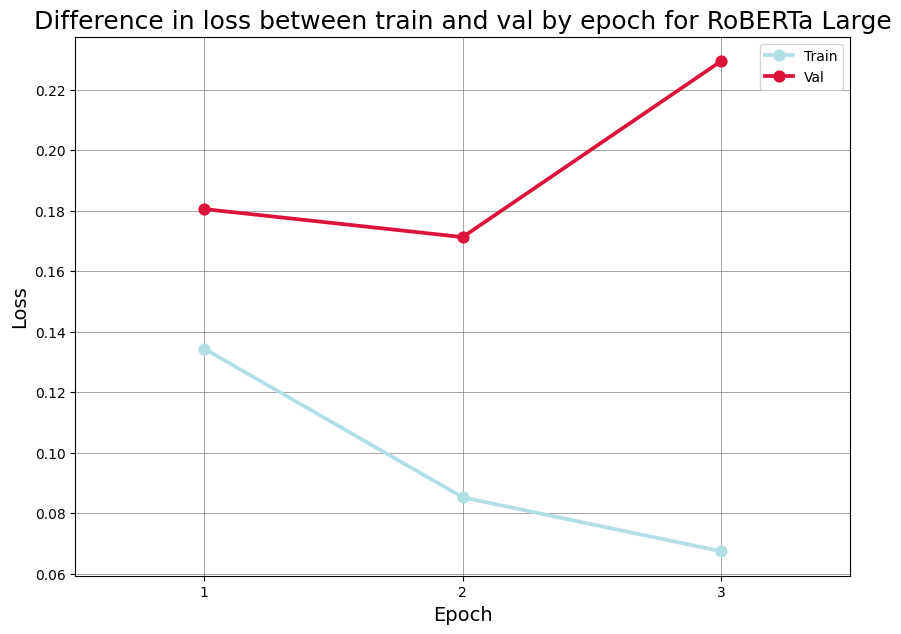

In [29]:
plot_dil(metrics_data, 'RoBERTa Large')

**Подбор порога вероятности**

In [25]:
find_best_t(y_proba_val, val_dfs)

Лучший порог: 0.2600
Лучший F1: 0.7012


0.26

### DeBERTa V3

Эта модель обучается параметром TextDataset равным 504, в то время как все остальные модели обучались с параметром 512. Это связанно с тем, что модель не поместилась в видеопамять с параметром 512.

In [14]:
tokenizer_deberta3 = AutoTokenizer.from_pretrained('microsoft/deberta-v3-base')

In [15]:
train_dataset = TextDataset(train_dfs, tokenizer_deberta3, max_length=504)
val_dataset = TextDataset(val_dfs, tokenizer_deberta3, max_length=504)
test_dataset = TextDataset(test_dfs, tokenizer_deberta3, max_length=504)

In [16]:
model_deberta3 = AutoModelForSequenceClassification.from_pretrained('microsoft/deberta-v3-base', num_labels=2)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
training_args = TrainingArguments(
    output_dir='./deberta3_training_results',
    eval_strategy='epoch',
    learning_rate=1e-5,
    warmup_ratio=0.1,
    lr_scheduler_type='linear',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy='epoch',
    metric_for_best_model='eval_loss',
    greater_is_better=False,
    load_best_model_at_end=True,
    fp16=True,
    report_to='none'
)

In [18]:
trainer = Trainer(
    model=model_deberta3,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_train_metrics
)

In [19]:
trainer.train()

Epoch,Training Loss,Validation Loss,Roc Auc,Pr Auc,F1,Accuracy,Precision,Recall
1,0.171000,0.183017,0.952248,0.774551,0.688225,0.926083,0.674010,0.703052
2,0.149400,0.168395,0.954882,0.787478,0.683995,0.932625,0.750429,0.628366
3,0.125500,0.188454,0.953813,0.782306,0.693238,0.928167,0.687125,0.699461


TrainOutput(global_step=9000, training_loss=0.16212663269042968, metrics={'train_runtime': 4797.2542, 'train_samples_per_second': 60.034, 'train_steps_per_second': 1.876, 'total_flos': 7.4593321915392e+16, 'train_loss': 0.16212663269042968, 'epoch': 3.0})

**Метрики и графики для лучшей полученной модели на выборках Train/val/test**

In [20]:
train_preds = trainer.predict(train_dataset)
val_preds = trainer.predict(val_dataset)
test_preds = trainer.predict(test_dataset)

y_train = train_preds.label_ids
y_val = val_preds.label_ids
y_test = test_preds.label_ids

y_pred_train = np.argmax(train_preds.predictions, axis=1)
y_pred_val = np.argmax(val_preds.predictions, axis=1)
y_pred_test = np.argmax(test_preds.predictions, axis=1)

y_proba_train = torch.softmax(torch.tensor(train_preds.predictions), dim=-1)[:, 1].numpy()
y_proba_val = torch.softmax(torch.tensor(val_preds.predictions), dim=-1)[:, 1].numpy()
y_proba_test = torch.softmax(torch.tensor(test_preds.predictions), dim=-1)[:, 1].numpy()

DeBERTa V3

Precision		Recall			F1

Train: 0.84		Train: 0.72		Train: 0.77
Val: 0.75		Val: 0.63		Val: 0.68
Test: 0.76		Test: 0.65		Test: 0.70


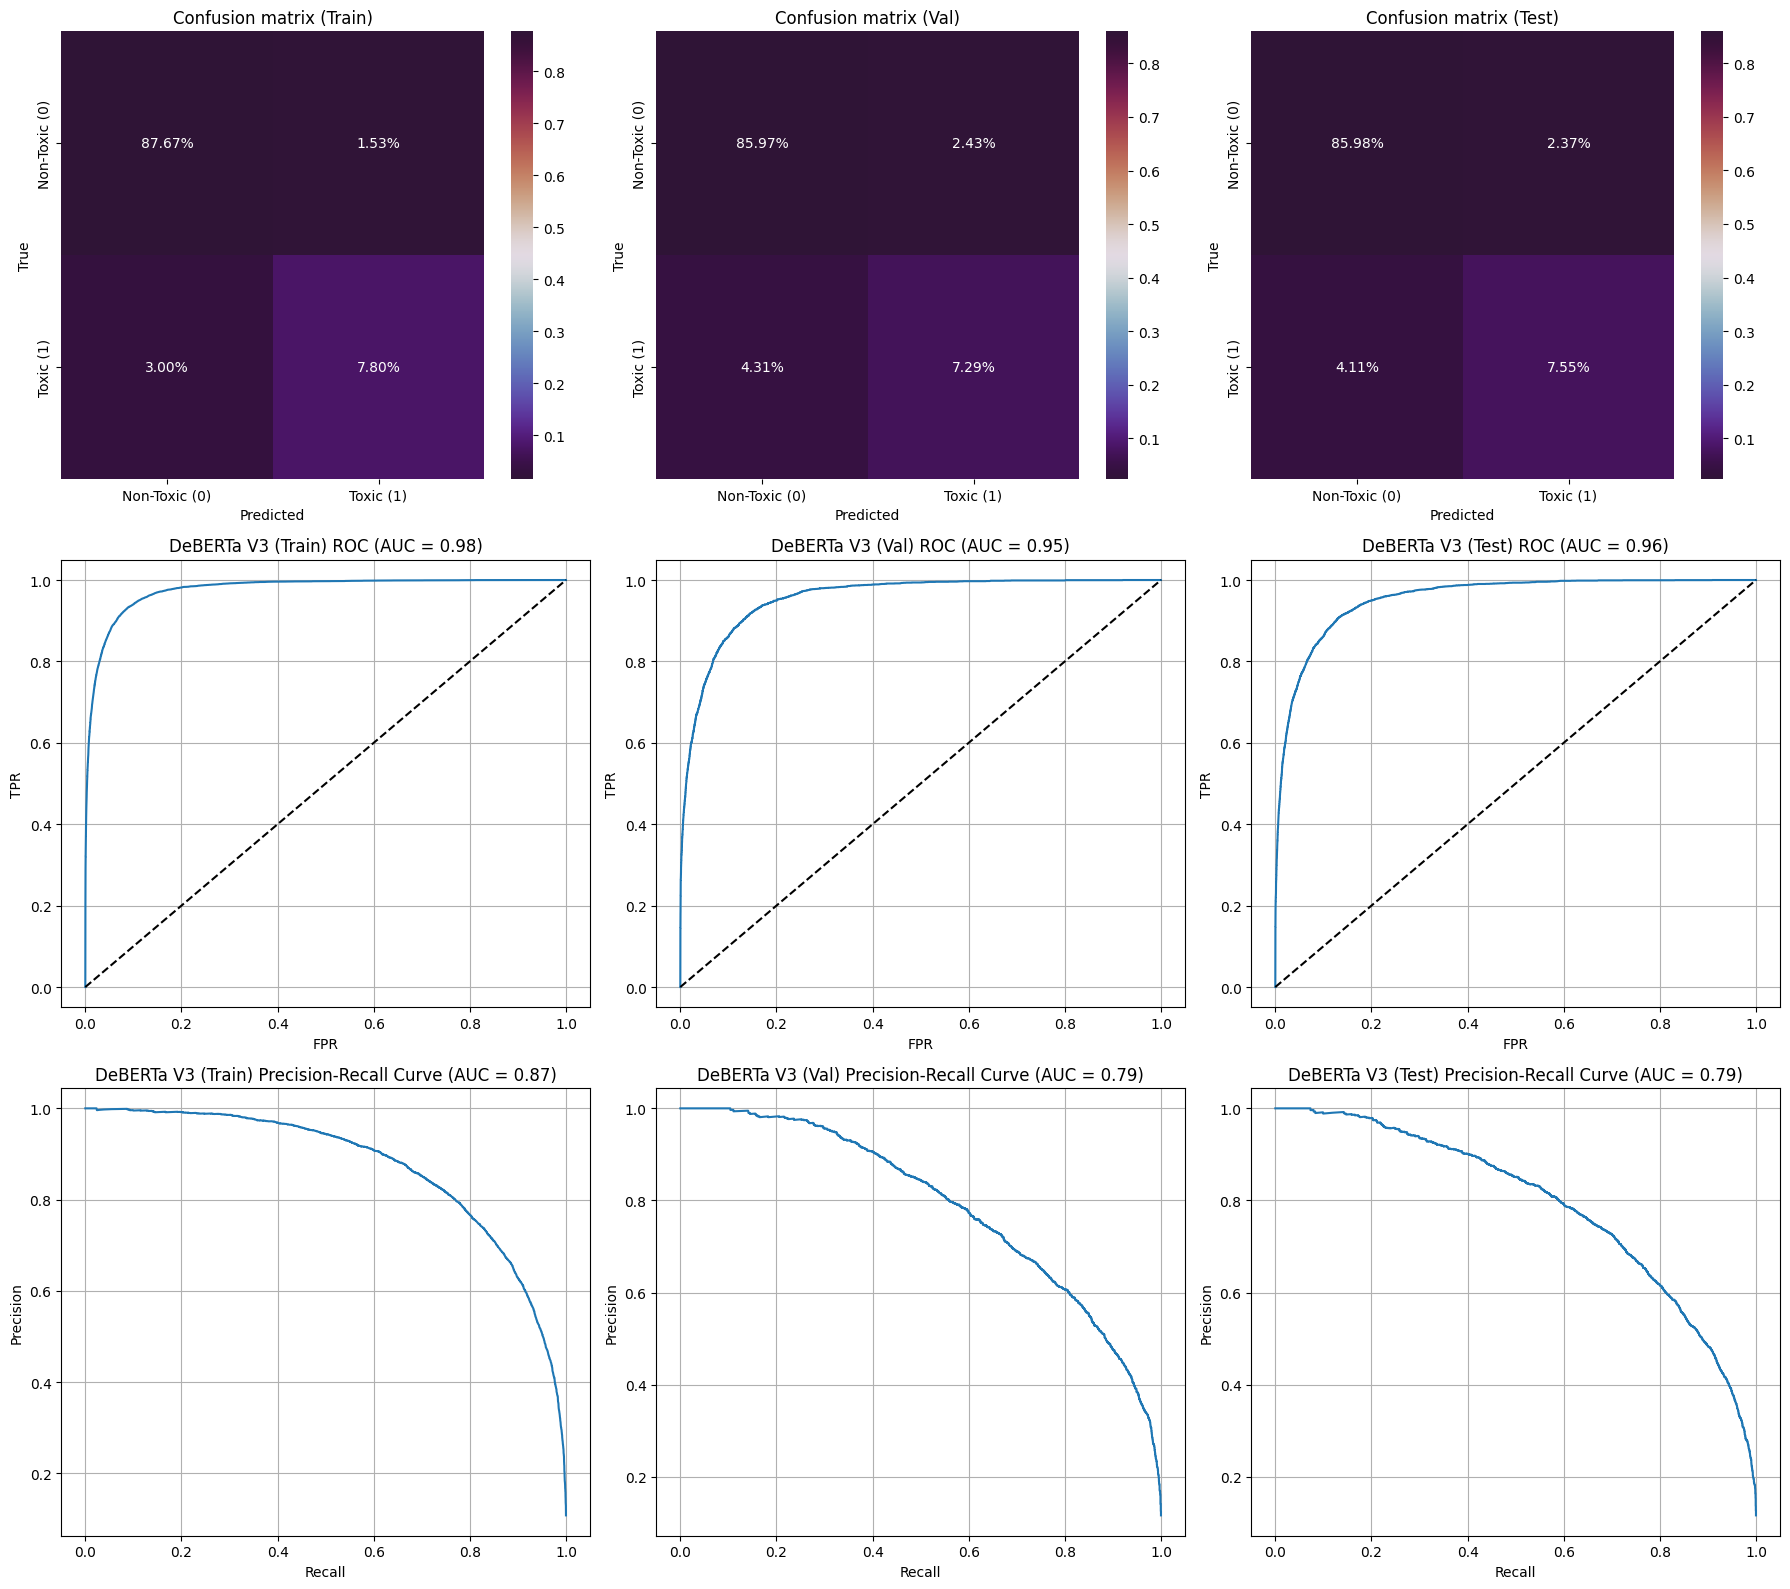

In [21]:
show_metrics(
    y_train, y_val, y_test,
    y_pred_train, y_pred_val, y_pred_test,
    y_proba_train, y_proba_val, y_proba_test,
    title="DeBERTa V3"
)

**Метрики по эпохам на train/val**

In [22]:
checkpoints = [
    './deberta3_training_results/checkpoint-3000',
    './deberta3_training_results/checkpoint-6000',
    './deberta3_training_results/checkpoint-9000'
]

In [23]:
all_metrics = []


datasets = [
    ("train", train_dataset),
    ("val", val_dataset),
]

for path in checkpoints:
    for name, dataset in datasets:
        metrics = evaluate_checkpoint(
            path=path,
            dataset=dataset,
            dataset_name=name,
            tokenizer=tokenizer_deberta3,
            compute_metrics=compute_train_metrics
        )
        all_metrics.append(metrics)

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: inreleppik (inreleppik-hse-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [24]:
metrics_data = pd.DataFrame(all_metrics)
metrics_data['epoch'] = [1, 1, 2, 2, 3, 3]
metrics_data = metrics_data[['eval_loss', 'eval_roc_auc', 'eval_pr_auc', 'eval_f1',
              'eval_accuracy', 'eval_precision', 'eval_recall', 'epoch', 'dataset']]

In [25]:
metrics_data

,eval_loss,eval_roc_auc,eval_pr_auc,eval_f1,eval_accuracy,eval_precision,eval_recall,epoch,dataset
0,0.146703,0.965694,0.822768,0.735989,0.941604,0.719322,0.753447,1,train
1,0.183017,0.952250,0.774549,0.688104,0.926042,0.673778,0.703052,1,val
2,0.113268,0.976450,0.872383,0.774891,0.954688,0.836256,0.721917,2,train
3,0.168400,0.954882,0.787472,0.683604,0.932542,0.750000,0.628007,2,val
4,0.109908,0.980151,0.889308,0.801651,0.956958,0.798203,0.805130,3,train
5,0.188464,0.953813,0.782295,0.693238,0.928167,0.687125,0.699461,3,val


**Loss на Train и Val по эпохам**

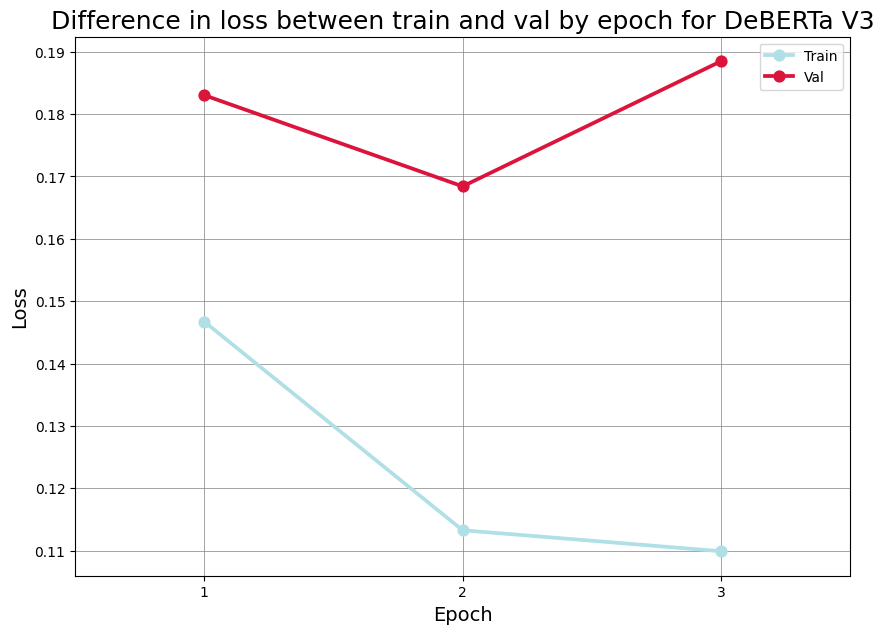

In [26]:
plot_dil(metrics_data, 'DeBERTa V3')

**Подбор порога вероятности**

In [27]:
find_best_t(y_proba_val, val_dfs)

Лучший порог: 0.3200
Лучший F1: 0.7004


0.32

### DeBERTa V3 Large

Эту модель удалось запустить только при условии того, что необходимо было урезать максимальную длину комментариев с 504 до 192. Иначе сама модель просто не помещается на видеокарту.

In [14]:
tokenizer_deberta3l = AutoTokenizer.from_pretrained('microsoft/deberta-v3-large')

In [15]:
train_dataset = TextDataset(train_dfs, tokenizer_deberta3l, max_length=192)
val_dataset = TextDataset(val_dfs, tokenizer_deberta3l, max_length=192)
test_dataset = TextDataset(test_dfs, tokenizer_deberta3l, max_length=192)

In [16]:
model_deberta3l = AutoModelForSequenceClassification.from_pretrained('microsoft/deberta-v3-large', num_labels=2)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
training_args = TrainingArguments(
    output_dir='./deberta3l_training_results',
    eval_strategy='epoch',
    learning_rate=1e-5,
    warmup_ratio=0.1,
    lr_scheduler_type='linear',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy='epoch',
    metric_for_best_model='eval_loss',
    greater_is_better=False,
    load_best_model_at_end=True,
    fp16=True,
    report_to='none'
)

In [18]:
trainer = Trainer(
    model=model_deberta3l,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_train_metrics
)

In [19]:
trainer.train()

Epoch,Training Loss,Validation Loss,Roc Auc,Pr Auc,F1,Accuracy,Precision,Recall
1,0.172200,0.175210,0.951158,0.773833,0.689486,0.931583,0.728326,0.654578
2,0.135600,0.175291,0.952399,0.781469,0.684488,0.932625,0.749573,0.629803
3,0.098600,0.212552,0.949062,0.775527,0.695744,0.927625,0.679207,0.713106


TrainOutput(global_step=9000, training_loss=0.1466986338297526, metrics={'train_runtime': 4324.5761, 'train_samples_per_second': 66.596, 'train_steps_per_second': 2.081, 'total_flos': 1.00649266716672e+17, 'train_loss': 0.1466986338297526, 'epoch': 3.0})

**Метрики и графики для лучшей полученной модели на выборках Train/val/test**

In [20]:
train_preds = trainer.predict(train_dataset)
val_preds = trainer.predict(val_dataset)
test_preds = trainer.predict(test_dataset)

y_train = train_preds.label_ids
y_val = val_preds.label_ids
y_test = test_preds.label_ids

y_pred_train = np.argmax(train_preds.predictions, axis=1)
y_pred_val = np.argmax(val_preds.predictions, axis=1)
y_pred_test = np.argmax(test_preds.predictions, axis=1)

y_proba_train = torch.softmax(torch.tensor(train_preds.predictions), dim=-1)[:, 1].numpy()
y_proba_val = torch.softmax(torch.tensor(val_preds.predictions), dim=-1)[:, 1].numpy()
y_proba_test = torch.softmax(torch.tensor(test_preds.predictions), dim=-1)[:, 1].numpy()

DeBERTa V3 Large 192

Precision		Recall			F1

Train: 0.79		Train: 0.73		Train: 0.76
Val: 0.73		Val: 0.65		Val: 0.69
Test: 0.73		Test: 0.66		Test: 0.69


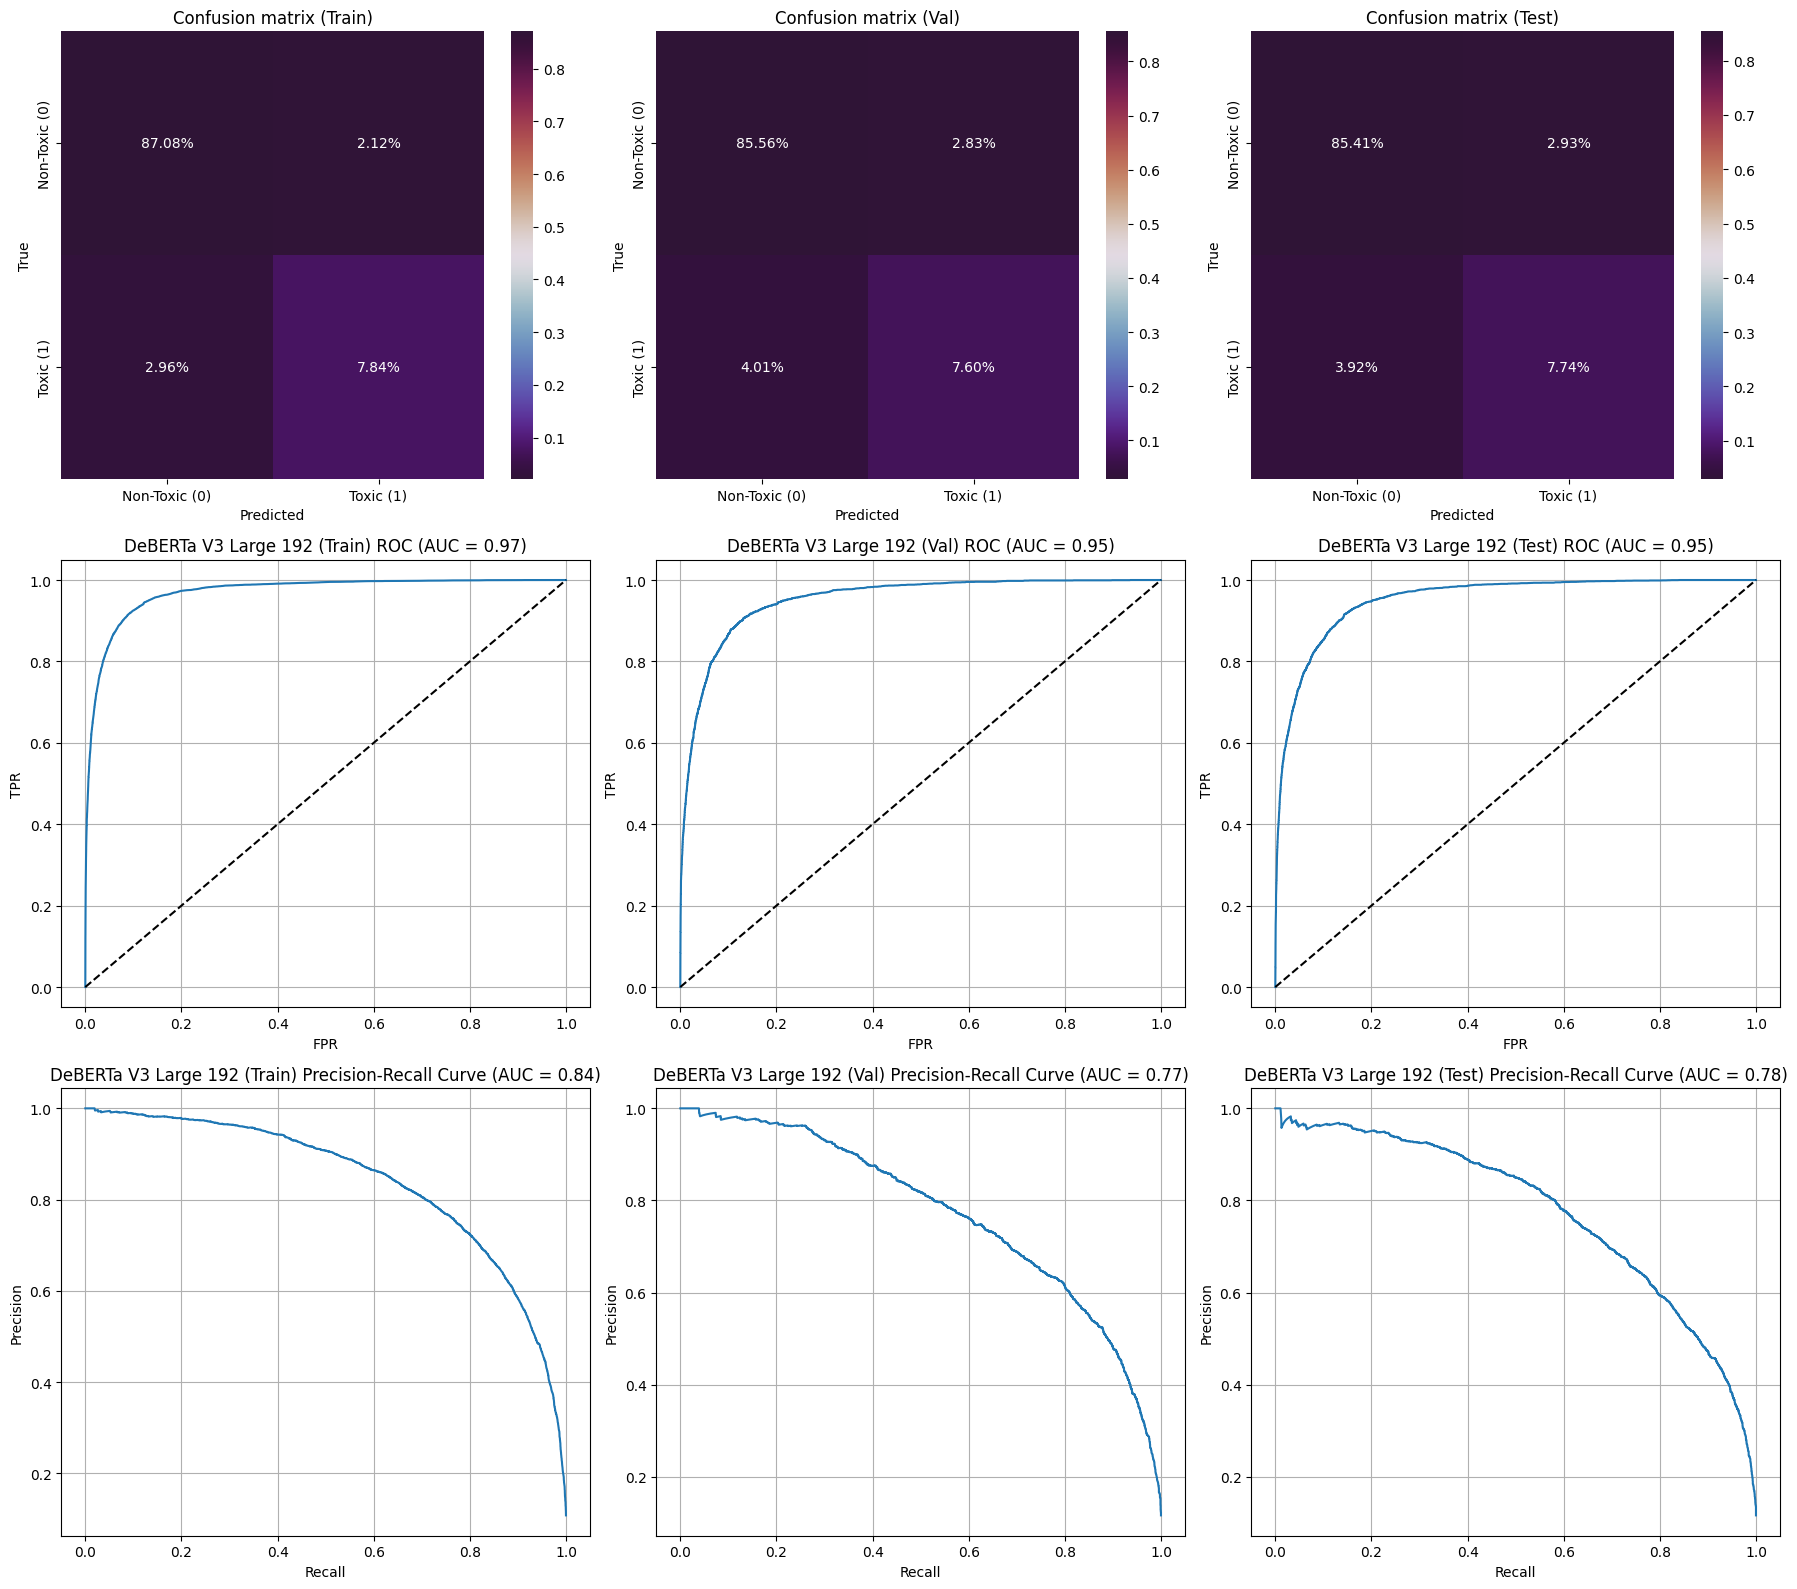

In [21]:
show_metrics(
    y_train, y_val, y_test,
    y_pred_train, y_pred_val, y_pred_test,
    y_proba_train, y_proba_val, y_proba_test,
    title="DeBERTa V3 Large 192"
)

**Метрики по эпохам на train/val**

In [22]:
checkpoints = [
    './deberta3l_training_results/checkpoint-3000',
    './deberta3l_training_results/checkpoint-6000',
    './deberta3l_training_results/checkpoint-9000'
]

In [23]:
all_metrics = []


datasets = [
    ("train", train_dataset),
    ("val", val_dataset),
]

for path in checkpoints:
    for name, dataset in datasets:
        metrics = evaluate_checkpoint(
            path=path,
            dataset=dataset,
            dataset_name=name,
            tokenizer=tokenizer_deberta3l,
            compute_metrics=compute_train_metrics
        )
        all_metrics.append(metrics)

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: inreleppik (inreleppik-hse-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [24]:
metrics_data = pd.DataFrame(all_metrics)
metrics_data['epoch'] = [1, 1, 2, 2, 3, 3]
metrics_data = metrics_data[['eval_loss', 'eval_roc_auc', 'eval_pr_auc', 'eval_f1',
              'eval_accuracy', 'eval_precision', 'eval_recall', 'epoch', 'dataset']]

In [25]:
metrics_data

,eval_loss,eval_roc_auc,eval_pr_auc,eval_f1,eval_accuracy,eval_precision,eval_recall,epoch,dataset
0,0.129668,0.969925,0.841222,0.755531,0.949240,0.787492,0.726063,1,train
1,0.175219,0.951149,0.773819,0.689486,0.931583,0.728326,0.654578,1,val
2,0.088381,0.985862,0.920124,0.837155,0.966854,0.892027,0.788641,2,train
3,0.175297,0.952400,0.781464,0.684477,0.932583,0.749040,0.630162,2,val
4,0.069580,0.991203,0.948781,0.885633,0.974875,0.871257,0.900492,3,train
5,0.212553,0.949061,0.775535,0.695744,0.927625,0.679207,0.713106,3,val


**Loss на Train и Val по эпохам**

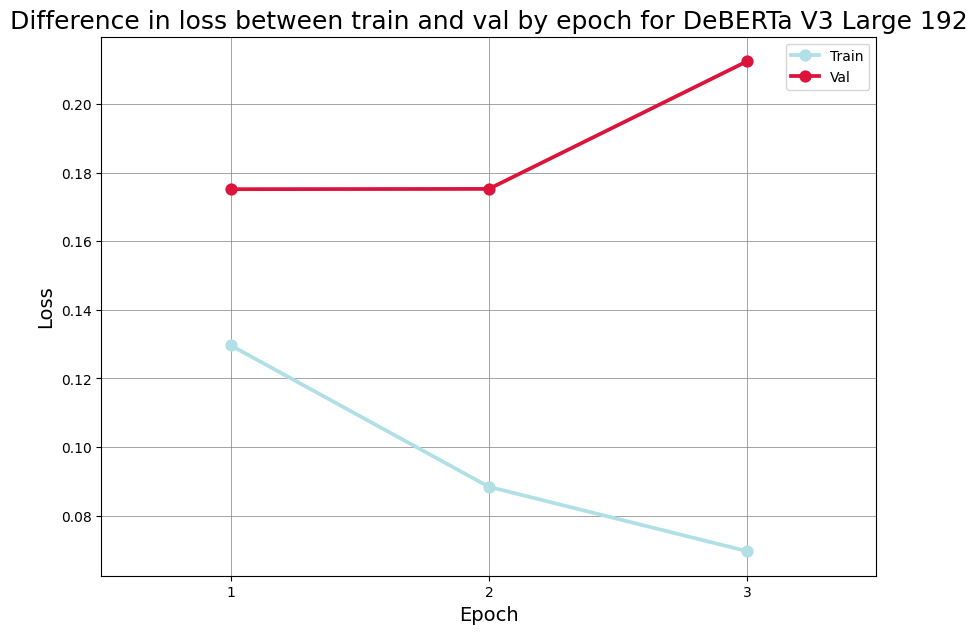

In [26]:
plot_dil(metrics_data, 'DeBERTa V3 Large 192')

**Подбор порога вероятности**

In [27]:
find_best_t(y_proba_val, val_dfs)

Лучший порог: 0.2900
Лучший F1: 0.6984


0.29000000000000004

### Xlmr Large Toxicity Classifier V2

In [14]:
textdetox_tokenizer = AutoTokenizer.from_pretrained('textdetox/xlmr-large-toxicity-classifier-v2')
textdetox_model = AutoModelForSequenceClassification.from_pretrained('textdetox/xlmr-large-toxicity-classifier-v2')

In [15]:
textdetox_frozen_model = freeze_layers(textdetox_model, num_frozen_layers=0)

In [16]:
train_dataset = TextDataset(train_dfs, textdetox_tokenizer)
val_dataset = TextDataset(val_dfs, textdetox_tokenizer)
test_dataset = TextDataset(test_dfs, textdetox_tokenizer)

In [17]:
training_args = TrainingArguments(
    output_dir='./textdetox_training_results',
    eval_strategy='epoch',
    learning_rate=1e-5,
    warmup_ratio=0.1,
    lr_scheduler_type='linear',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy='epoch',
    metric_for_best_model='eval_loss',
    greater_is_better=False,
    load_best_model_at_end=True,
    fp16=True,
    report_to='none'
)

In [18]:
trainer = Trainer(
    model=textdetox_frozen_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_train_metrics
)

In [19]:
trainer.train()

Epoch,Training Loss,Validation Loss,Roc Auc,Pr Auc,F1,Accuracy,Precision,Recall
1,0.172000,0.190216,0.950826,0.762855,0.690253,0.927042,0.680265,0.700539
2,0.145100,0.170760,0.952768,0.784905,0.686538,0.932083,0.739130,0.640934
3,0.107100,0.216423,0.950583,0.777465,0.691651,0.926292,0.672087,0.712388


TrainOutput(global_step=9000, training_loss=0.14663736809624567, metrics={'train_runtime': 7164.2462, 'train_samples_per_second': 40.2, 'train_steps_per_second': 1.256, 'total_flos': 2.68396232638464e+17, 'train_loss': 0.14663736809624567, 'epoch': 3.0})

**Метрики и графики для лучшей полученной модели на выборках Train/val/test**

In [20]:
train_preds = trainer.predict(train_dataset)
val_preds = trainer.predict(val_dataset)
test_preds = trainer.predict(test_dataset)

y_train = train_preds.label_ids
y_val = val_preds.label_ids
y_test = test_preds.label_ids

y_pred_train = np.argmax(train_preds.predictions, axis=1)
y_pred_val = np.argmax(val_preds.predictions, axis=1)
y_pred_test = np.argmax(test_preds.predictions, axis=1)

y_proba_train = torch.softmax(torch.tensor(train_preds.predictions), dim=-1)[:, 1].numpy()
y_proba_val = torch.softmax(torch.tensor(val_preds.predictions), dim=-1)[:, 1].numpy()
y_proba_test = torch.softmax(torch.tensor(test_preds.predictions), dim=-1)[:, 1].numpy()

Xlmr Large Toxicity Classifier V2

Precision		Recall			F1

Train: 0.88		Train: 0.79		Train: 0.83
Val: 0.74		Val: 0.64		Val: 0.69
Test: 0.76		Test: 0.66		Test: 0.70


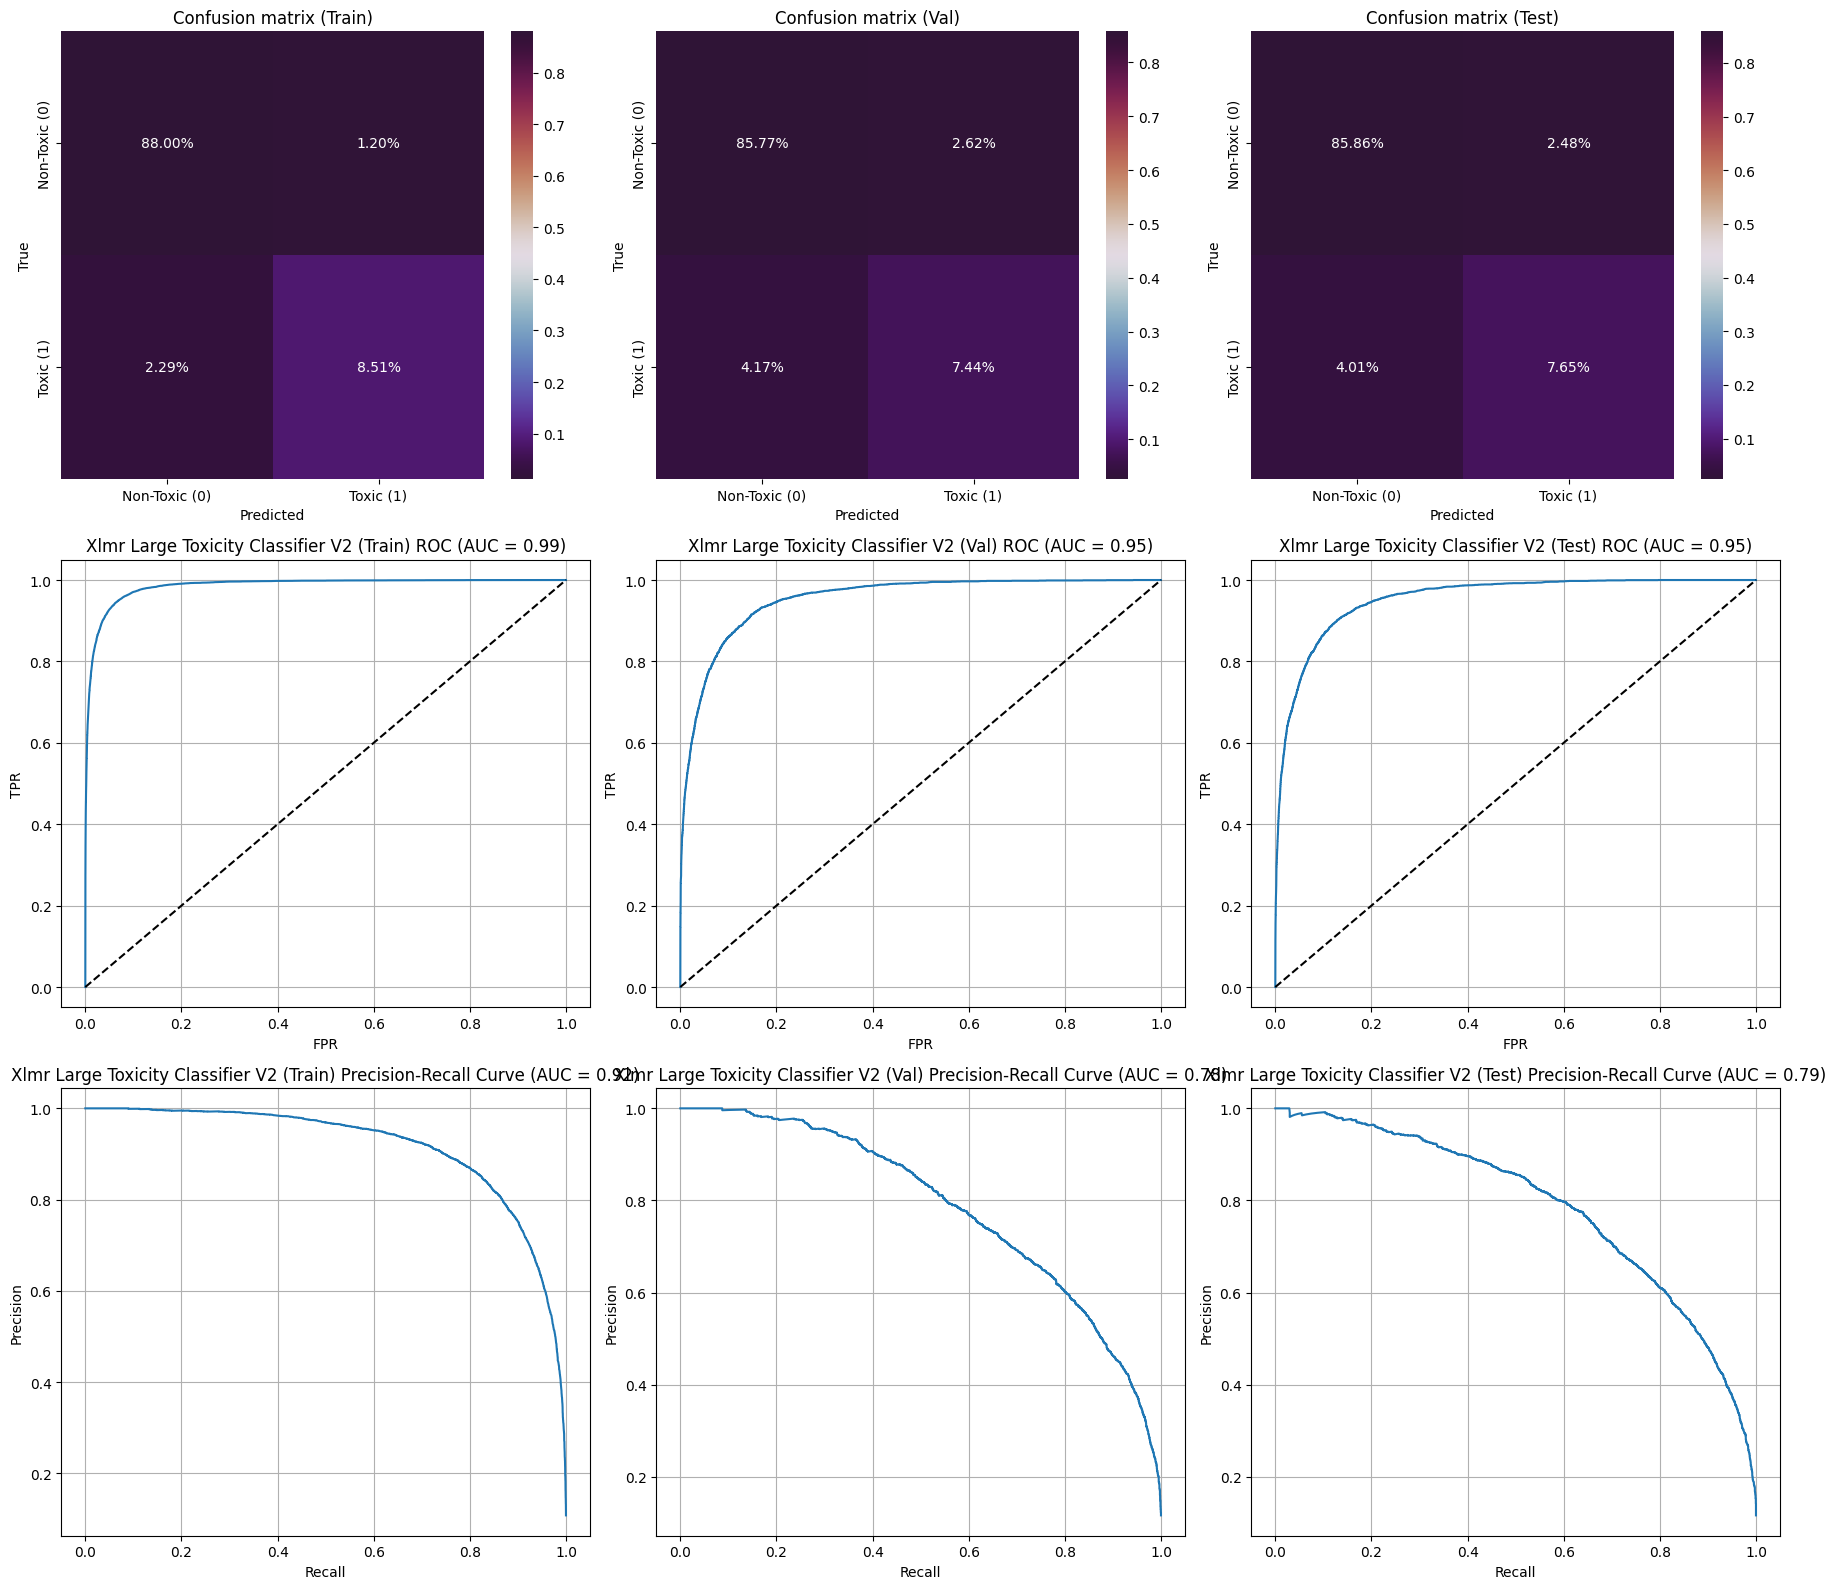

In [21]:
show_metrics(
    y_train, y_val, y_test,
    y_pred_train, y_pred_val, y_pred_test,
    y_proba_train, y_proba_val, y_proba_test,
    title="Xlmr Large Toxicity Classifier V2"
)

**Метрики по эпохам на train/val**

In [22]:
checkpoints = [
    './textdetox_training_results/checkpoint-3000',
    './textdetox_training_results/checkpoint-6000',
    './textdetox_training_results/checkpoint-9000'
]

In [23]:
all_metrics = []


datasets = [
    ("train", train_dataset),
    ("val", val_dataset),
]

for path in checkpoints:
    for name, dataset in datasets:
        metrics = evaluate_checkpoint(
            path=path,
            dataset=dataset,
            dataset_name=name,
            tokenizer=textdetox_tokenizer,
            compute_metrics=compute_train_metrics
        )
        all_metrics.append(metrics)

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: inreleppik (inreleppik-hse-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [24]:
metrics_data = pd.DataFrame(all_metrics)
metrics_data['epoch'] = [1, 1, 2, 2, 3, 3]
metrics_data = metrics_data[['eval_loss', 'eval_roc_auc', 'eval_pr_auc', 'eval_f1',
              'eval_accuracy', 'eval_precision', 'eval_recall', 'epoch', 'dataset']]

In [25]:
metrics_data

,eval_loss,eval_roc_auc,eval_pr_auc,eval_f1,eval_accuracy,eval_precision,eval_recall,epoch,dataset
0,0.142432,0.969274,0.826552,0.742144,0.943156,0.727669,0.757208,1,train
1,0.190223,0.950825,0.762864,0.690253,0.927042,0.680265,0.700539,1,val
2,0.089781,0.985462,0.916008,0.829635,0.965052,0.876314,0.787677,2,train
3,0.170761,0.952766,0.784909,0.686418,0.932083,0.739329,0.640575,2,val
4,0.076282,0.990347,0.943274,0.871845,0.971490,0.847442,0.897695,3,train
5,0.216420,0.950586,0.777470,0.691530,0.926250,0.671859,0.712388,3,val


**Loss на Train и Val по эпохам**

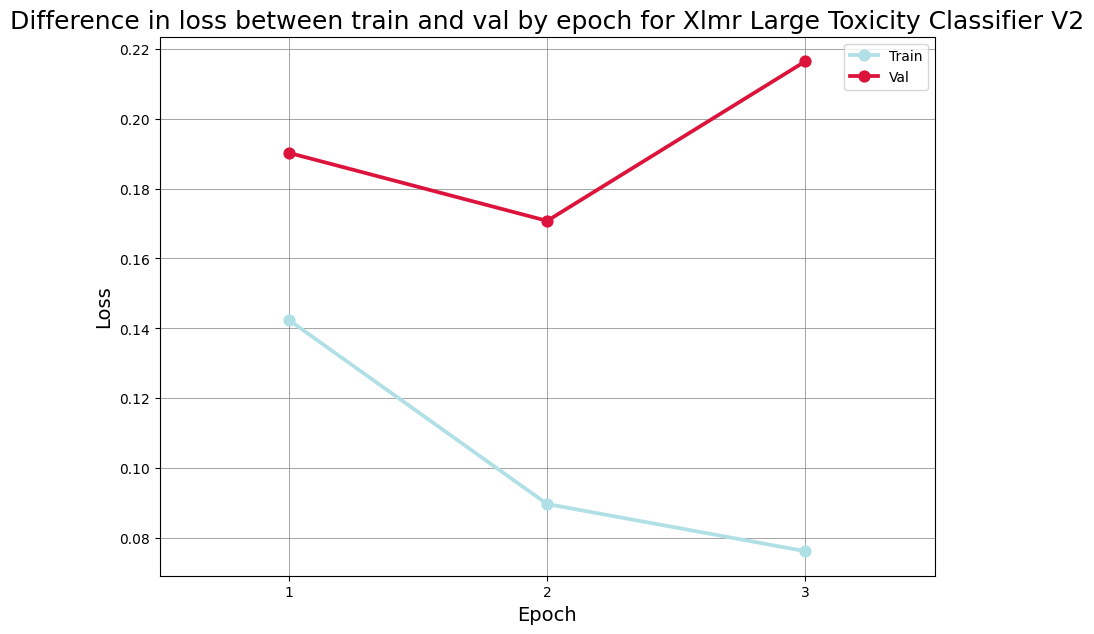

In [26]:
plot_dil(metrics_data, 'Xlmr Large Toxicity Classifier V2')

**Подбор порога вероятности**

In [27]:
find_best_t(y_proba_val, val_dfs)

Лучший порог: 0.2500
Лучший F1: 0.6991


0.25

### Hate-speech-CNERG/dehatebert-mono-english

In [14]:
hs_tokenizer = AutoTokenizer.from_pretrained('Hate-speech-CNERG/dehatebert-mono-english')
hs_model = AutoModelForSequenceClassification.from_pretrained('Hate-speech-CNERG/dehatebert-mono-english')

In [15]:
train_dataset = TextDataset(train_dfs, hs_tokenizer)
val_dataset = TextDataset(val_dfs, hs_tokenizer)
test_dataset = TextDataset(test_dfs, hs_tokenizer)

In [16]:
training_args = TrainingArguments(
    output_dir='./hs_training_results',
    eval_strategy='epoch',
    learning_rate=1e-5,
    warmup_ratio=0.1,
    lr_scheduler_type='linear',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy='epoch',
    metric_for_best_model='eval_loss',
    greater_is_better=False,
    load_best_model_at_end=True,
    fp16=True,
    report_to='none'
)

In [17]:
trainer = Trainer(
    model=hs_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_train_metrics
)

In [18]:
trainer.train()

Epoch,Training Loss,Validation Loss,Roc Auc,Pr Auc,F1,Accuracy,Precision,Recall
1,0.212500,0.274683,0.902517,0.651420,0.596646,0.900792,0.564785,0.632316
2,0.202600,0.214146,0.914863,0.694610,0.616400,0.920083,0.695711,0.553321
3,0.194700,0.229582,0.917188,0.697931,0.633389,0.917375,0.652820,0.615081


TrainOutput(global_step=9000, training_loss=0.21053125762939454, metrics={'train_runtime': 2648.1475, 'train_samples_per_second': 108.755, 'train_steps_per_second': 3.399, 'total_flos': 7.577598394368e+16, 'train_loss': 0.21053125762939454, 'epoch': 3.0})

**Метрики и графики для лучшей полученной модели на выборках Train/val/test**

In [19]:
train_preds = trainer.predict(train_dataset)
val_preds = trainer.predict(val_dataset)
test_preds = trainer.predict(test_dataset)

y_train = train_preds.label_ids
y_val = val_preds.label_ids
y_test = test_preds.label_ids

y_pred_train = np.argmax(train_preds.predictions, axis=1)
y_pred_val = np.argmax(val_preds.predictions, axis=1)
y_pred_test = np.argmax(test_preds.predictions, axis=1)

y_proba_train = torch.softmax(torch.tensor(train_preds.predictions), dim=-1)[:, 1].numpy()
y_proba_val = torch.softmax(torch.tensor(val_preds.predictions), dim=-1)[:, 1].numpy()
y_proba_test = torch.softmax(torch.tensor(test_preds.predictions), dim=-1)[:, 1].numpy()

DeHateBERT Mono English

Precision		Recall			F1

Train: 0.73		Train: 0.60		Train: 0.66
Val: 0.70		Val: 0.55		Val: 0.62
Test: 0.69		Test: 0.55		Test: 0.61


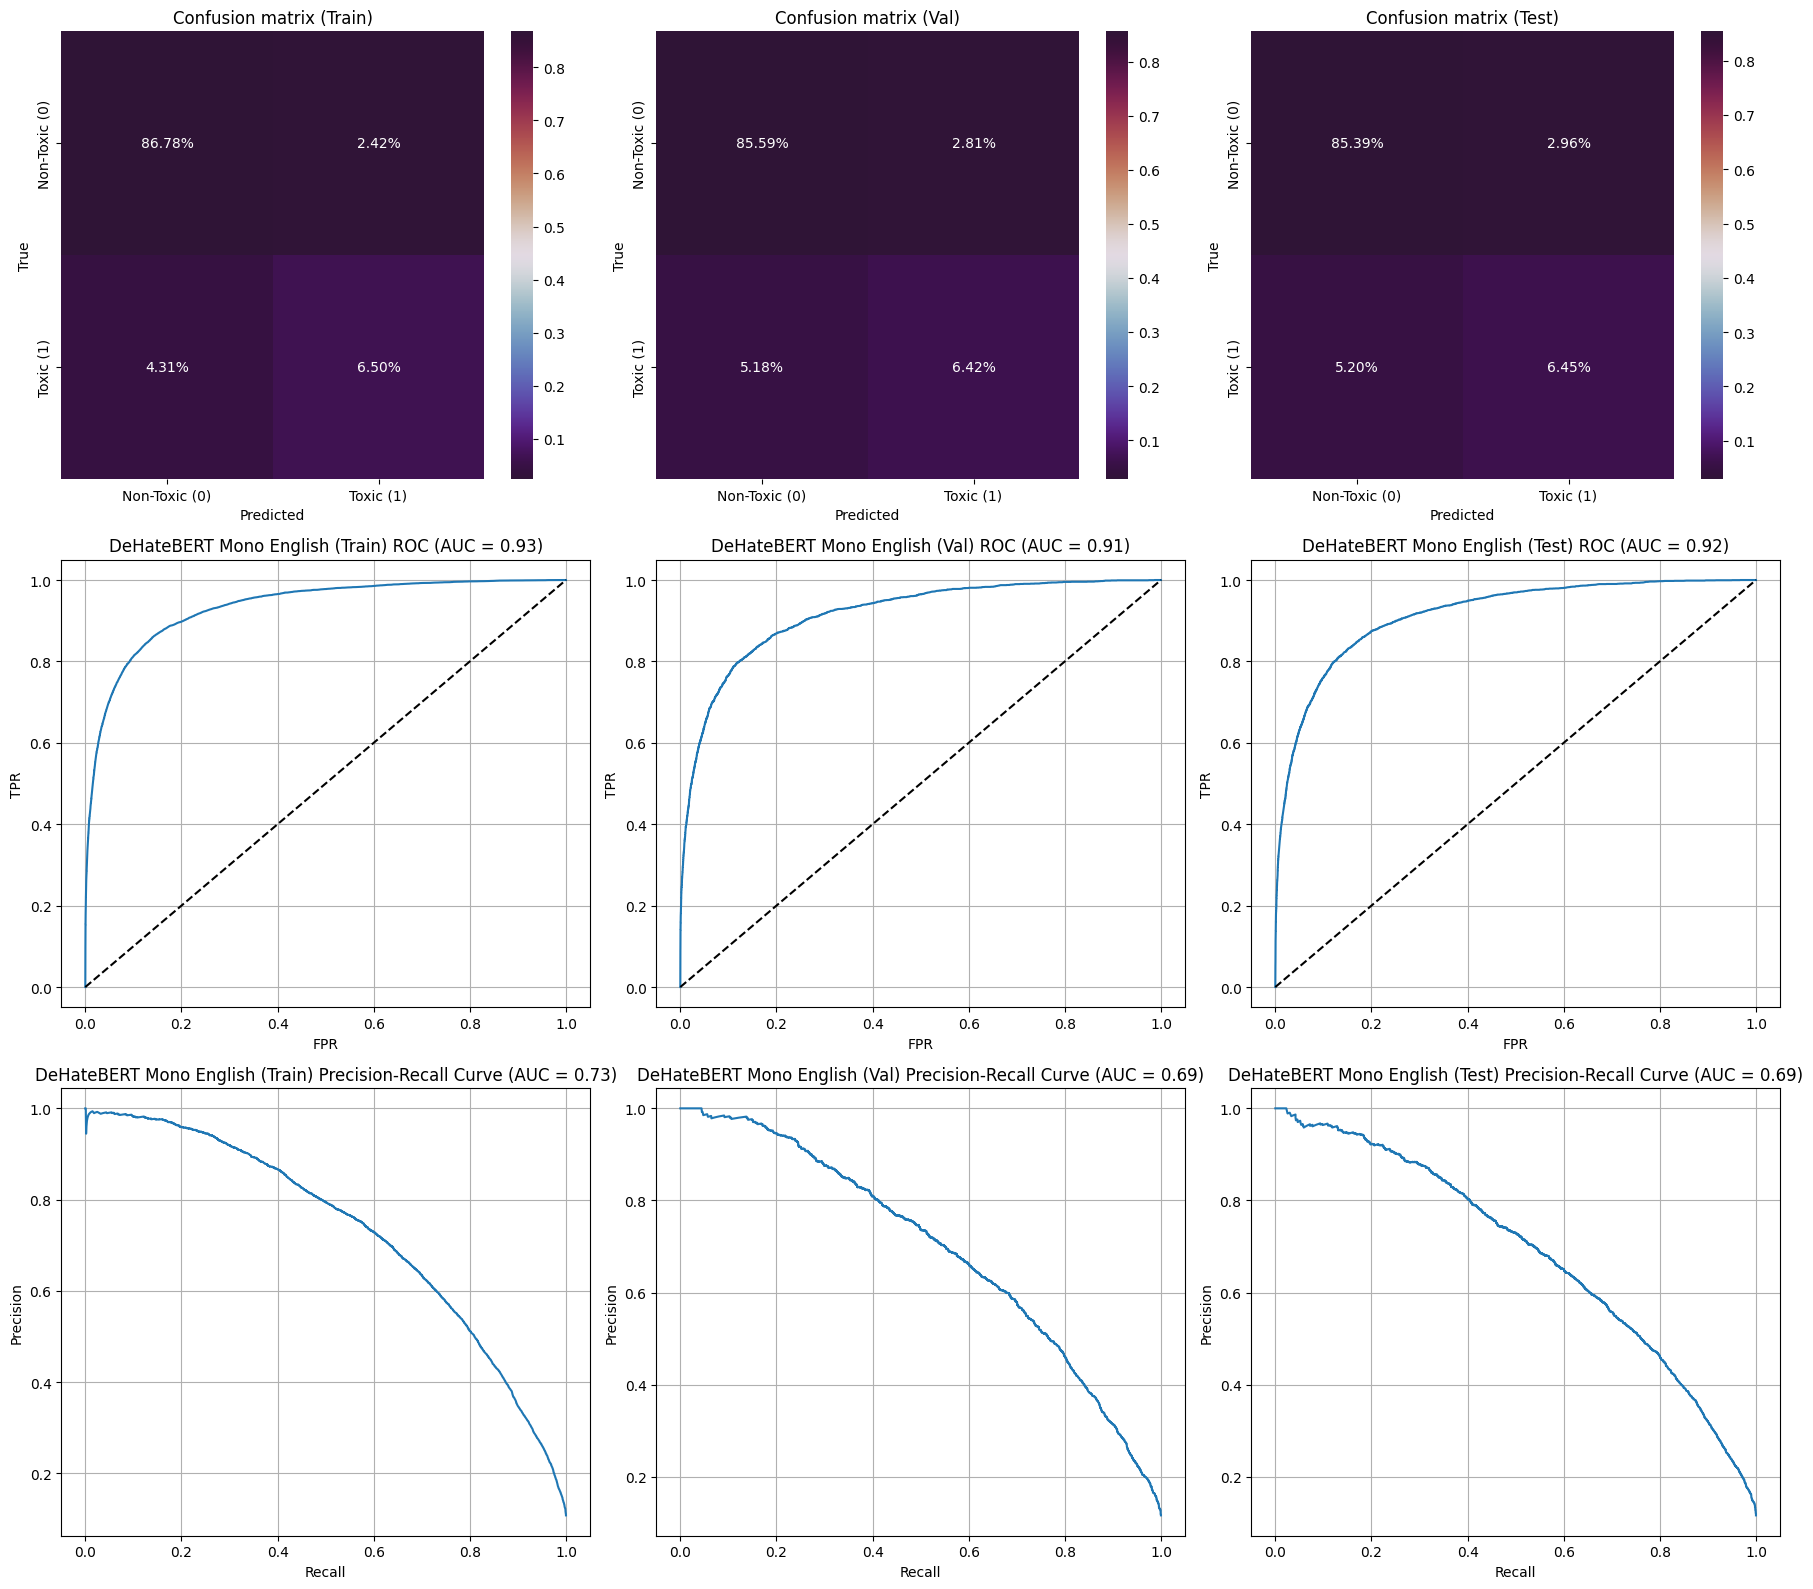

In [20]:
show_metrics(
    y_train, y_val, y_test,
    y_pred_train, y_pred_val, y_pred_test,
    y_proba_train, y_proba_val, y_proba_test,
    title="DeHateBERT Mono English"
)

**Метрики по эпохам на train/val**

In [21]:
checkpoints = [
    './hs_training_results/checkpoint-3000',
    './hs_training_results/checkpoint-6000',
    './hs_training_results/checkpoint-9000'
]

In [22]:
all_metrics = []


datasets = [
    ("train", train_dataset),
    ("val", val_dataset),
]

for path in checkpoints:
    for name, dataset in datasets:
        metrics = evaluate_checkpoint(
            path=path,
            dataset=dataset,
            dataset_name=name,
            tokenizer=hs_tokenizer,
            compute_metrics=compute_train_metrics
        )
        all_metrics.append(metrics)

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: inreleppik (inreleppik-hse-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [23]:
metrics_data = pd.DataFrame(all_metrics)
metrics_data['epoch'] = [1, 1, 2, 2, 3, 3]
metrics_data = metrics_data[['eval_loss', 'eval_roc_auc', 'eval_pr_auc', 'eval_f1',
              'eval_accuracy', 'eval_precision', 'eval_recall', 'epoch', 'dataset']]

In [24]:
metrics_data

,eval_loss,eval_roc_auc,eval_pr_auc,eval_f1,eval_accuracy,eval_precision,eval_recall,epoch,dataset
0,0.251788,0.914754,0.672294,0.611159,0.910344,0.574974,0.652203,1,train
1,0.274682,0.902520,0.651387,0.596545,0.900750,0.564604,0.632316,1,val
2,0.182302,0.933261,0.733689,0.658850,0.932719,0.728451,0.601388,2,train
3,0.214143,0.914864,0.694612,0.616400,0.920083,0.695711,0.553321,2,val
4,0.188654,0.937397,0.748259,0.679699,0.932073,0.692731,0.667149,3,train
5,0.229585,0.917185,0.697919,0.633389,0.917375,0.652820,0.615081,3,val


**Loss на Train и Val по эпохам**

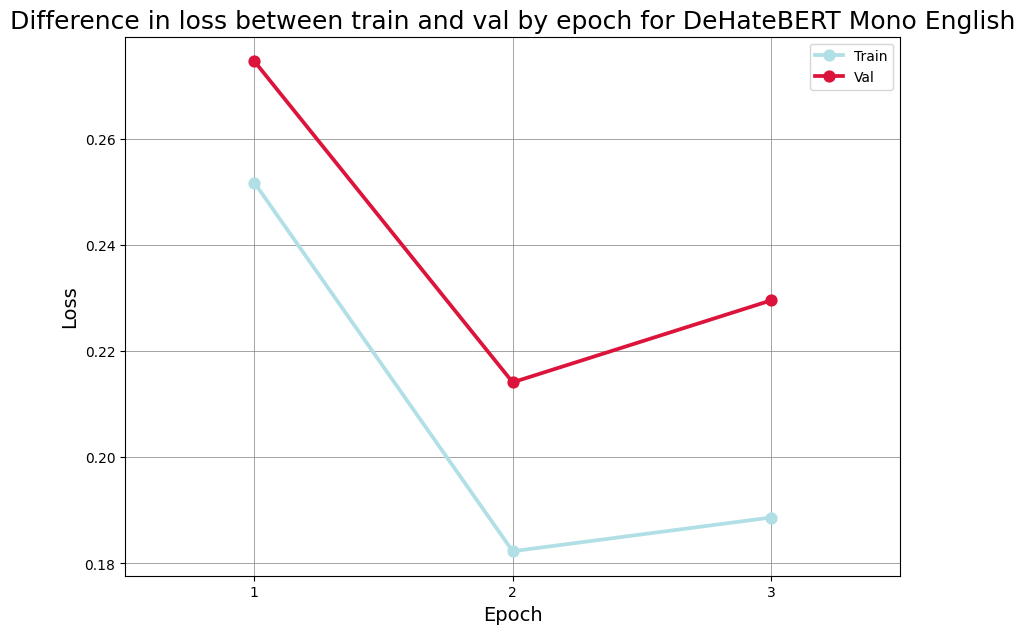

In [25]:
plot_dil(metrics_data, 'DeHateBERT Mono English')

**Подбор порога вероятности**

In [26]:
find_best_t(y_proba_val, val_dfs)

Лучший порог: 0.2700
Лучший F1: 0.6383


0.27

## Обучение моделей на полных данных